In [1]:
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu, compute_az_el_dist
import numpy as np
import json, gc, pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import importlib, minmax_solvers
importlib.reload(minmax_solvers)
from minmax_solvers import solve_game_bestresp_Q0_then_Q1
# Your utils
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu
from sionna.rt import PlanarArray


import numpy as np
from numpy.linalg import cholesky, solve, eigh


c = 3e8  # speed of light (m/s)
fc = 10e9  # Carrier frequency: 10 GHz
wavelength = c / fc
bandwidth = 100e6  # 100 MHz
tx_power_dbm = 50  #  dBm
jam_power_dbm = 70
k = 1.38e-23  # Boltzmann 
GT = 13 # db gain-to-noise-temperature for for 0.33m Equivalent satellite antenna aperturesatellites, or can be 5 dB K^(-1) for 0.13m Equivalent satellite antenna aperture
La = 5 # dB
GT_linear_inv = 10 ** (-GT / 10)
La_linear = 10 ** (La / 10)
noise_power_watt = k * bandwidth * GT_linear_inv * La_linear
Tx_power_watt = 10 ** ((tx_power_dbm  - 30)/ 10)  
Jam_power_watt = 10 ** ((jam_power_dbm  - 30)/ 10)
T_sys = 150.0 
N0 = k * bandwidth * T_sys* La_linear

# N0 = noise_power_watt
P0 = Tx_power_watt
P1 = Jam_power_watt

jitc_llvm_init(): LLVM API initialization failed ..


In [2]:
from sionna.rt import Receiver, Transmitter, PlanarArray, PathSolver, load_scene
import numpy as np
import vsat_dish_3gpp


def compute_cir(tx_pos, rx_pos, tx_array, rx_array,tx_look_at, rx_look_at, frequency=10e9):
    """
    Compute CIR from a single transmitter to multiple receivers using synthetic arrays.
    
    Args:
        tx_pos:        (3,) list or np.array for transmitter position
        rx_pos_array:  (m,3) array of receiver positions
        tx_array:      PlanarArray for the transmitter
        rx_array:      PlanarArray for all receivers (shared)
        frequency:     Frequency in Hz

    Returns:
        a_list:    list of CIR amplitude arrays, one per RX
        tau_list:  list of delay arrays, one per RX
    """
    scene = load_scene()
    scene.frequency = frequency
    scene.synthetic_array = True
    
    for tx_name in scene.transmitters:
        scene.remove(tx_name)
    for rx_name in scene.receivers:
        scene.remove(rx_name) 

    # Add transmitter
    scene.tx_array = tx_array
    tx = Transmitter(name="tx", position=tx_pos, display_radius=200)
    scene.add(tx)
    
    earth_radius_m = 6371e3
    rx_look_at2 = np.array([0.0, 0.0, -1*earth_radius_m/2])
    
    if isinstance(tx_look_at, str) and tx_look_at.lower() in ["up-z", "up", "z"]:
        tx_look_at = np.array(tx_pos) + np.array([0.0, 0.0, 1.0])
    tx.look_at(tx_look_at)
    # Add receivers
    scene.rx_array = rx_array
    rx_list = []
    for i, rx_pos in enumerate(rx_pos):
        rx = Receiver(name=f"rx{i}", position=rx_pos)
        scene.add(rx)
        rx.look_at(rx_look_at2)
        rx_list.append(rx)
    tx.look_at( tx_look_at)

    # Solve paths
    solver = PathSolver()
    paths = solver(scene=scene,
                   max_depth=0,
                   los=True,
                   synthetic_array=True,
                #    seed=41
                   )

    # Get CIRs
    a_all, tau_all = paths.cir(normalize_delays=False, out_type="numpy")

    for tx_name in scene.transmitters:
        scene.remove(tx_name)
    for rx_name in scene.receivers:
        scene.remove(rx_name) 
    
    return a_all, tau_all

jam_rows =6
jam_cols = 6
jam_antennas = jam_cols*jam_rows

sat_rows = 6
sat_cols = 6
sat_antennas = sat_cols*sat_rows

tx_rows = 6
tx_cols = 6
tx_antennas = tx_cols*tx_rows

tx_array = PlanarArray(num_rows=tx_rows, num_cols=tx_cols,
                        vertical_spacing=0.5, horizontal_spacing=0.5,
                        pattern="tr38901", polarization="V")
                        # pattern="iso", polarization="V")

jam_array = PlanarArray(num_rows=jam_rows, num_cols=jam_cols,  
                            vertical_spacing=0.5, horizontal_spacing=0.5,
                        #  pattern="vsat_dish",
                            pattern="tr38901",
                            polarization="V")

sat_array = PlanarArray(num_rows=sat_rows, num_cols=sat_cols,
                             vertical_spacing=0.5, horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

def collapse_channel(a_cir, t_idx=0):
    """
    Collapse channel tensor at a given time index.
    Input:
      a_cir: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
    Output:
      H_t: (M, N), M = num_rx*num_rx_ant, N = num_tx*num_tx_ant
    """
    nr, nra, nt, nta, npaths, ntimes = a_cir.shape
    assert 0 <= t_idx < ntimes
    H_t = a_cir[..., t_idx]             # select time slice
    H_t = H_t.sum(axis=-1)              # sum over paths
    H_t = H_t.reshape(nr*nra, nt*nta)   # merge Rx/Tx antennas
    return H_t


In [3]:
  
    

def make_tqdm_progress(total, desc, position=1, leave=False):
    bar = tqdm(total=total, desc=desc, position=position,
                  leave=leave, dynamic_ncols=True, miniters=1, mininterval=0.0)
    bar.refresh()  
    last_i = 0

    def _cb(i=None, total=None, metrics=None, ctx=None):
        nonlocal last_i
        if i is not None:
            di = int(i) - int(last_i)     
            if di > 0:
                bar.update(di)
                last_i = i
        if metrics:
            show = {k: (f"{v:.3e}" if ("res" in k or "err" in k) else f"{v:.4f}")
                    for k, v in metrics.items()}
            bar.set_postfix(show, refresh=True)  
        return False

    _cb.close = bar.close
    return _cb

In [4]:

# Load and make sure each time block is ordered by Rank (nearest first)
df = pd.read_csv("tracked_satellites_400.csv")
df = df.sort_values(["Time", "Rank"], ascending=[True, True]).reset_index(drop=True)
n_steps = df["Time"].nunique()
print("Total steps:", n_steps)
# max_steps = 3
# print(df.head(max_steps*5))

Total steps: 400


In [5]:
# Generate RX positions

distances_km = [7]
azimuths_deg = np.linspace(0, 360, len(distances_km), endpoint=False)
gnd_positions = [np.array([0.0, 0.0, 0.0])]

for d_km, az in zip(distances_km, azimuths_deg):
    pos = arc_point_on_earth(d_km, az)
    gnd_positions.append(pos)
gnd_positions = np.array(gnd_positions)

for i, pos in enumerate(gnd_positions):
    print(f"TX{i}(m): {pos}")

TX0(m): [0. 0. 0.]
TX1(m): [ 4.28626293e-13  6.99999859e+03 -3.84554976e+00]


In [6]:

# ---- JSON 序列化器：支持 numpy / complex ----
class NumpyEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, (np.integer,)):  return int(o)
        if isinstance(o, (np.floating,)): return float(o)
        if isinstance(o, (np.complexfloating, complex)):
            return {"__complex__":[float(o.real), float(o.imag)]}
        if isinstance(o, np.ndarray):     return o.tolist()
        return super().default(o)
    

max_steps = n_steps

methods = ["BestResp"]
sat_counts = [1, 3, 5] 
groups = list(df.sort_values(["Time","Rank"]).groupby("Time"))

# ---- 单文件（非压缩）增量写入 ----

buffer = []                              # 暂存多条，降低 I/O 次数
FLUSH_EVERY = 20                     # 每 5 个 time-step 落盘一次
out_path = "allarray7km.jsonl"
f_out = open(out_path, "a", encoding="utf-8")
with open(out_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

if len(lines) > 0:
    last_entry = json.loads(lines[-1])
    last_step = last_entry["step_idx"]
else:
    last_step = 0
start_step = last_step + 1
for step_idx, (t, g) in enumerate(tqdm(groups[start_step-1:], desc="Processing steps"), start=start_step):
    # If more/less than k are present, we still proceed with available rows
    gk = g.sort_values("Rank").copy()

    # Build sat_positions in ENU (meters)
    sat_positions = gk[["x_East (m)", "y_North (m)", "z_Up (m)"]].to_numpy()  # (K,3)
    names = gk["Name"].tolist()
    K_all = sat_positions.shape[0]

    a_tx,  tau_tx  = compute_cir(gnd_positions[0], sat_positions, tx_array, sat_array, 
                                 np.array(gnd_positions[0]) + np.array([0.0, 0.0, 100.0]), gnd_positions[0])
    a_jam, tau_jam = compute_cir(gnd_positions[1], sat_positions, jam_array, sat_array, 
                                 np.array(gnd_positions[1]) + np.array([0.0, 0.0, 100.0]), gnd_positions[0])
    
    H0_full = collapse_channel(a_tx)
    H1_full = collapse_channel(a_jam)

    
    for k_sel in sat_counts:
        if K_all < k_sel:
            continue  # 该时刻不足 k_sel 颗，跳过
        
        
        # 取前 k_sel 颗卫星对应的行块（按 Rank 的顺序）
        H0 = H0_full[:k_sel*sat_antennas, :]
        H1 = H1_full[:k_sel*sat_antennas, :]

        # 均分初始化 Q1
        n1 = H1.shape[1]
        Q1_init = (P1/n1) * np.eye(n1, dtype=complex)
        
        for m in methods:
            desc = f"{m} | t#{step_idx}/{len(groups)} | k={k_sel} | sats={','.join(names[:k_sel])}"
            if m == "BestResp":
                
                inner = make_tqdm_progress(total=200, desc=desc, position=1, leave=False)  # total 用该 solver 设定的最大步数
                try:
                    Q0, Q1, n_it, hist = solve_game_bestresp_Q0_then_Q1(
                        H0, H1, N0,
                        P0=P0, P1=P1,
                        max_outer=200, tol=1e-6, inner_Q1_steps=2,
                        geometry='entropy', step_rule='adp',
                        eta=0.8, eta_init=1,
                        eta_min=1.5e-1, eta_max=1000,
                        beta=0.5, gamma=1.05,
                        multi_stream=True, verbose=False, track_hist=True,
                        Q1_init=Q1_init,
                        progress=inner,                 # <<< 关键：传进去
                        progress_every=1,
                        progress_ctx={"method": m, "k": k_sel, "time": str(t), "step_idx": step_idx}
                    )
                finally:
                    inner.close()
            else:
                raise ValueError(f"Unknown method {m}")
            
            # ---- 写入缓冲（只留一份文件；不把大结果长期放内存）----
            entry = {
                "time": (pd.Timestamp(t).isoformat() if not pd.isna(t) else None),
                "step_idx": step_idx,
                "method": m,
                "k": k_sel,
                "sat_names": names[:k_sel],
                "hist": hist,                    # 如需瘦身：改成摘要，例如 {"J_final": hist["J"][-1], ...}
            }
            buffer.append(entry)

            # 释放当前条目的大对象
            del Q0, Q1, hist, entry
            gc.collect()
            
            
    # ---- 每 N 步批量写入并清空缓冲 ----
    if (step_idx % FLUSH_EVERY == 0) or (step_idx == len(groups)) or (step_idx >= max_steps):
        for e in buffer:
            f_out.write(json.dumps(e, cls=NumpyEncoder) + "\n")
        f_out.flush()
        buffer.clear()
        gc.collect()
        print(f"[flush] wrote up to step {step_idx}")
    if step_idx >= max_steps:
        break

# 结束：关闭文件
f_out.close()
print(f"✅ Incremental results saved to {out_path}")

Processing steps:   0%|          | 0/400 [00:00<?, ?it/s]

BestResp | t#1/400 | k=1 | sats=STARLINK-32842:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#1/400 | k=3 | sats=STARLINK-32842,STARLINK-31923,STARLINK-32416:   0%|          | 0/200 [00:00<?,…

BestResp | t#1/400 | k=5 | sats=STARLINK-32842,STARLINK-31923,STARLINK-32416,STARLINK-33754,STARLINK-32143:   …

BestResp | t#2/400 | k=1 | sats=STARLINK-11076 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#2/400 | k=3 | sats=STARLINK-11076 [DTC],STARLINK-32155,STARLINK-1738:   0%|          | 0/200 [00:…

BestResp | t#2/400 | k=5 | sats=STARLINK-11076 [DTC],STARLINK-32155,STARLINK-1738,STARLINK-32704,STARLINK-3500…

BestResp | t#3/400 | k=1 | sats=STARLINK-35247:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#3/400 | k=3 | sats=STARLINK-35247,STARLINK-32844,STARLINK-30936:   0%|          | 0/200 [00:00<?,…

BestResp | t#3/400 | k=5 | sats=STARLINK-35247,STARLINK-32844,STARLINK-30936,STARLINK-31559,STARLINK-34868:   …

BestResp | t#4/400 | k=1 | sats=STARLINK-32207:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#4/400 | k=3 | sats=STARLINK-32207,STARLINK-33744,STARLINK-31907:   0%|          | 0/200 [00:00<?,…

BestResp | t#4/400 | k=5 | sats=STARLINK-32207,STARLINK-33744,STARLINK-31907,STARLINK-32269,STARLINK-6356:   0…

BestResp | t#5/400 | k=1 | sats=STARLINK-11668 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#5/400 | k=3 | sats=STARLINK-11668 [DTC],STARLINK-31997,STARLINK-31812:   0%|          | 0/200 [00…

BestResp | t#5/400 | k=5 | sats=STARLINK-11668 [DTC],STARLINK-31997,STARLINK-31812,STARLINK-31199,STARLINK-629…

BestResp | t#6/400 | k=1 | sats=STARLINK-11072 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#6/400 | k=3 | sats=STARLINK-11072 [DTC],STARLINK-31812,STARLINK-32480:   0%|          | 0/200 [00…

BestResp | t#6/400 | k=5 | sats=STARLINK-11072 [DTC],STARLINK-31812,STARLINK-32480,STARLINK-32188,STARLINK-319…

BestResp | t#7/400 | k=1 | sats=STARLINK-30896:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#7/400 | k=3 | sats=STARLINK-30896,STARLINK-31316,STARLINK-32843:   0%|          | 0/200 [00:00<?,…

BestResp | t#7/400 | k=5 | sats=STARLINK-30896,STARLINK-31316,STARLINK-32843,STARLINK-32212,STARLINK-31200:   …

BestResp | t#8/400 | k=1 | sats=STARLINK-30896:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#8/400 | k=3 | sats=STARLINK-30896,STARLINK-31316,STARLINK-32843:   0%|          | 0/200 [00:00<?,…

BestResp | t#8/400 | k=5 | sats=STARLINK-30896,STARLINK-31316,STARLINK-32843,STARLINK-31200,STARLINK-35007:   …

BestResp | t#9/400 | k=1 | sats=STARLINK-31532:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#9/400 | k=3 | sats=STARLINK-31532,STARLINK-32223,STARLINK-32159:   0%|          | 0/200 [00:00<?,…

BestResp | t#9/400 | k=5 | sats=STARLINK-31532,STARLINK-32223,STARLINK-32159,STARLINK-31213,STARLINK-31926:   …

BestResp | t#10/400 | k=1 | sats=STARLINK-11274 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#10/400 | k=3 | sats=STARLINK-11274 [DTC],STARLINK-32630,STARLINK-30950:   0%|          | 0/200 [0…

BestResp | t#10/400 | k=5 | sats=STARLINK-11274 [DTC],STARLINK-32630,STARLINK-30950,STARLINK-31030,STARLINK-31…

BestResp | t#11/400 | k=1 | sats=STARLINK-11670 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#11/400 | k=3 | sats=STARLINK-11670 [DTC],STARLINK-11606 [DTC],STARLINK-31057:   0%|          | 0/…

BestResp | t#11/400 | k=5 | sats=STARLINK-11670 [DTC],STARLINK-11606 [DTC],STARLINK-31057,STARLINK-31306,STARL…

BestResp | t#12/400 | k=1 | sats=STARLINK-30110:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#12/400 | k=3 | sats=STARLINK-30110,STARLINK-33570,STARLINK-32653:   0%|          | 0/200 [00:00<?…

BestResp | t#12/400 | k=5 | sats=STARLINK-30110,STARLINK-33570,STARLINK-32653,STARLINK-30953,STARLINK-31477:  …

BestResp | t#13/400 | k=1 | sats=STARLINK-11315 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#13/400 | k=3 | sats=STARLINK-11315 [DTC],STARLINK-11497 [DTC],STARLINK-33563:   0%|          | 0/…

BestResp | t#13/400 | k=5 | sats=STARLINK-11315 [DTC],STARLINK-11497 [DTC],STARLINK-33563,STARLINK-33595,STARL…

BestResp | t#14/400 | k=1 | sats=STARLINK-11315 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#14/400 | k=3 | sats=STARLINK-11315 [DTC],STARLINK-11497 [DTC],STARLINK-33595:   0%|          | 0/…

BestResp | t#14/400 | k=5 | sats=STARLINK-11315 [DTC],STARLINK-11497 [DTC],STARLINK-33595,STARLINK-33563,STARL…

BestResp | t#15/400 | k=1 | sats=STARLINK-32386:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#15/400 | k=3 | sats=STARLINK-32386,STARLINK-32664,STARLINK-30933:   0%|          | 0/200 [00:00<?…

BestResp | t#15/400 | k=5 | sats=STARLINK-32386,STARLINK-32664,STARLINK-30933,STARLINK-33718,STARLINK-4356:   …

BestResp | t#16/400 | k=1 | sats=STARLINK-11464 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#16/400 | k=3 | sats=STARLINK-11464 [DTC],STARLINK-11340 [DTC],STARLINK-33582:   0%|          | 0/…

BestResp | t#16/400 | k=5 | sats=STARLINK-11464 [DTC],STARLINK-11340 [DTC],STARLINK-33582,STARLINK-32662,STARL…

BestResp | t#17/400 | k=1 | sats=STARLINK-11438 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#17/400 | k=3 | sats=STARLINK-11438 [DTC],STARLINK-33549,STARLINK-31046:   0%|          | 0/200 [0…

BestResp | t#17/400 | k=5 | sats=STARLINK-11438 [DTC],STARLINK-33549,STARLINK-31046,STARLINK-31552,STARLINK-51…

BestResp | t#18/400 | k=1 | sats=STARLINK-11682 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#18/400 | k=3 | sats=STARLINK-11682 [DTC],STARLINK-32284,STARLINK-32791:   0%|          | 0/200 [0…

BestResp | t#18/400 | k=5 | sats=STARLINK-11682 [DTC],STARLINK-32284,STARLINK-32791,STARLINK-32510,STARLINK-33…

BestResp | t#19/400 | k=1 | sats=STARLINK-11461 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#19/400 | k=3 | sats=STARLINK-11461 [DTC],STARLINK-11178 [DTC],STARLINK-32940:   0%|          | 0/…

BestResp | t#19/400 | k=5 | sats=STARLINK-11461 [DTC],STARLINK-11178 [DTC],STARLINK-32940,STARLINK-35162,STARL…

BestResp | t#20/400 | k=1 | sats=STARLINK-30912:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#20/400 | k=3 | sats=STARLINK-30912,STARLINK-31320,STARLINK-31899:   0%|          | 0/200 [00:00<?…

BestResp | t#20/400 | k=5 | sats=STARLINK-30912,STARLINK-31320,STARLINK-31899,STARLINK-33735,STARLINK-30193:  …

[flush] wrote up to step 20


BestResp | t#21/400 | k=1 | sats=STARLINK-11376 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#21/400 | k=3 | sats=STARLINK-11376 [DTC],STARLINK-32666,STARLINK-31502:   0%|          | 0/200 [0…

BestResp | t#21/400 | k=5 | sats=STARLINK-11376 [DTC],STARLINK-32666,STARLINK-31502,STARLINK-32547,STARLINK-26…

BestResp | t#22/400 | k=1 | sats=STARLINK-11434 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#22/400 | k=3 | sats=STARLINK-11434 [DTC],STARLINK-11518 [DTC],STARLINK-31937:   0%|          | 0/…

BestResp | t#22/400 | k=5 | sats=STARLINK-11434 [DTC],STARLINK-11518 [DTC],STARLINK-31937,STARLINK-32362,STARL…

BestResp | t#23/400 | k=1 | sats=STARLINK-30494:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#23/400 | k=3 | sats=STARLINK-30494,STARLINK-11500 [DTC],STARLINK-32012:   0%|          | 0/200 [0…

BestResp | t#23/400 | k=5 | sats=STARLINK-30494,STARLINK-11500 [DTC],STARLINK-32012,STARLINK-1767,STARLINK-319…

BestResp | t#24/400 | k=1 | sats=STARLINK-11437 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#24/400 | k=3 | sats=STARLINK-11437 [DTC],STARLINK-11632 [DTC],STARLINK-32749:   0%|          | 0/…

BestResp | t#24/400 | k=5 | sats=STARLINK-11437 [DTC],STARLINK-11632 [DTC],STARLINK-32749,STARLINK-5281,STARLI…

BestResp | t#25/400 | k=1 | sats=STARLINK-11437 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#25/400 | k=3 | sats=STARLINK-11437 [DTC],STARLINK-11632 [DTC],STARLINK-32749:   0%|          | 0/…

BestResp | t#25/400 | k=5 | sats=STARLINK-11437 [DTC],STARLINK-11632 [DTC],STARLINK-32749,STARLINK-5281,STARLI…

BestResp | t#26/400 | k=1 | sats=STARLINK-11459 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#26/400 | k=3 | sats=STARLINK-11459 [DTC],STARLINK-32609,STARLINK-32318:   0%|          | 0/200 [0…

BestResp | t#26/400 | k=5 | sats=STARLINK-11459 [DTC],STARLINK-32609,STARLINK-32318,STARLINK-5576,STARLINK-320…

BestResp | t#27/400 | k=1 | sats=STARLINK-11459 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#27/400 | k=3 | sats=STARLINK-11459 [DTC],STARLINK-32609,STARLINK-32318:   0%|          | 0/200 [0…

BestResp | t#27/400 | k=5 | sats=STARLINK-11459 [DTC],STARLINK-32609,STARLINK-32318,STARLINK-31925,STARLINK-55…

BestResp | t#28/400 | k=1 | sats=STARLINK-11432 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#28/400 | k=3 | sats=STARLINK-11432 [DTC],STARLINK-11625 [DTC],STARLINK-31760:   0%|          | 0/…

BestResp | t#28/400 | k=5 | sats=STARLINK-11432 [DTC],STARLINK-11625 [DTC],STARLINK-31760,STARLINK-35275,STARL…

BestResp | t#29/400 | k=1 | sats=STARLINK-33673:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#29/400 | k=3 | sats=STARLINK-33673,STARLINK-11505 [DTC],STARLINK-11373 [DTC]:   0%|          | 0/…

BestResp | t#29/400 | k=5 | sats=STARLINK-33673,STARLINK-11505 [DTC],STARLINK-11373 [DTC],STARLINK-31931,STARL…

BestResp | t#30/400 | k=1 | sats=STARLINK-31931:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#30/400 | k=3 | sats=STARLINK-31931,STARLINK-33673,STARLINK-32720:   0%|          | 0/200 [00:00<?…

BestResp | t#30/400 | k=5 | sats=STARLINK-31931,STARLINK-33673,STARLINK-32720,STARLINK-5572,STARLINK-34704:   …

BestResp | t#31/400 | k=1 | sats=STARLINK-11630 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#31/400 | k=3 | sats=STARLINK-11630 [DTC],STARLINK-32691,STARLINK-34488:   0%|          | 0/200 [0…

BestResp | t#31/400 | k=5 | sats=STARLINK-11630 [DTC],STARLINK-32691,STARLINK-34488,STARLINK-31825,STARLINK-30…

BestResp | t#32/400 | k=1 | sats=STARLINK-11630 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#32/400 | k=3 | sats=STARLINK-11630 [DTC],STARLINK-32691,STARLINK-34488:   0%|          | 0/200 [0…

BestResp | t#32/400 | k=5 | sats=STARLINK-11630 [DTC],STARLINK-32691,STARLINK-34488,STARLINK-31825,STARLINK-30…

BestResp | t#33/400 | k=1 | sats=STARLINK-11371 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#33/400 | k=3 | sats=STARLINK-11371 [DTC],STARLINK-31504,STARLINK-11343 [DTC]:   0%|          | 0/…

BestResp | t#33/400 | k=5 | sats=STARLINK-11371 [DTC],STARLINK-31504,STARLINK-11343 [DTC],STARLINK-32739,STARL…

BestResp | t#34/400 | k=1 | sats=STARLINK-32701:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#34/400 | k=3 | sats=STARLINK-32701,STARLINK-5320,STARLINK-32675:   0%|          | 0/200 [00:00<?,…

BestResp | t#34/400 | k=5 | sats=STARLINK-32701,STARLINK-5320,STARLINK-32675,STARLINK-33701,STARLINK-31223:   …

BestResp | t#35/400 | k=1 | sats=STARLINK-11624 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#35/400 | k=3 | sats=STARLINK-11624 [DTC],STARLINK-11435 [DTC],STARLINK-1759:   0%|          | 0/2…

BestResp | t#35/400 | k=5 | sats=STARLINK-11624 [DTC],STARLINK-11435 [DTC],STARLINK-1759,STARLINK-34361,STARLI…

BestResp | t#36/400 | k=1 | sats=STARLINK-32713:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#36/400 | k=3 | sats=STARLINK-32713,STARLINK-35222,STARLINK-32567:   0%|          | 0/200 [00:00<?…

BestResp | t#36/400 | k=5 | sats=STARLINK-32713,STARLINK-35222,STARLINK-32567,STARLINK-31158,STARLINK-32330:  …

BestResp | t#37/400 | k=1 | sats=STARLINK-34280:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#37/400 | k=3 | sats=STARLINK-34280,STARLINK-34221,STARLINK-33613:   0%|          | 0/200 [00:00<?…

BestResp | t#37/400 | k=5 | sats=STARLINK-34280,STARLINK-34221,STARLINK-33613,STARLINK-34414,STARLINK-5239:   …

BestResp | t#38/400 | k=1 | sats=STARLINK-11590 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#38/400 | k=3 | sats=STARLINK-11590 [DTC],STARLINK-35137,STARLINK-11477 [DTC]:   0%|          | 0/…

BestResp | t#38/400 | k=5 | sats=STARLINK-11590 [DTC],STARLINK-35137,STARLINK-11477 [DTC],STARLINK-31217,STARL…

BestResp | t#39/400 | k=1 | sats=STARLINK-11400 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#39/400 | k=3 | sats=STARLINK-11400 [DTC],STARLINK-32433,STARLINK-34222:   0%|          | 0/200 [0…

BestResp | t#39/400 | k=5 | sats=STARLINK-11400 [DTC],STARLINK-32433,STARLINK-34222,STARLINK-32332,STARLINK-34…

BestResp | t#40/400 | k=1 | sats=STARLINK-11405 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#40/400 | k=3 | sats=STARLINK-11405 [DTC],STARLINK-34421,STARLINK-34191:   0%|          | 0/200 [0…

BestResp | t#40/400 | k=5 | sats=STARLINK-11405 [DTC],STARLINK-34421,STARLINK-34191,STARLINK-32500,STARLINK-31…

[flush] wrote up to step 40


BestResp | t#41/400 | k=1 | sats=STARLINK-11405 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#41/400 | k=3 | sats=STARLINK-11405 [DTC],STARLINK-31226,STARLINK-5228:   0%|          | 0/200 [00…

BestResp | t#41/400 | k=5 | sats=STARLINK-11405 [DTC],STARLINK-31226,STARLINK-5228,STARLINK-31658,STARLINK-300…

BestResp | t#42/400 | k=1 | sats=STARLINK-11293 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#42/400 | k=3 | sats=STARLINK-11293 [DTC],STARLINK-32486,STARLINK-34795:   0%|          | 0/200 [0…

BestResp | t#42/400 | k=5 | sats=STARLINK-11293 [DTC],STARLINK-32486,STARLINK-34795,STARLINK-30556,STARLINK-34…

BestResp | t#43/400 | k=1 | sats=STARLINK-33872:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#43/400 | k=3 | sats=STARLINK-33872,STARLINK-30995,STARLINK-31583:   0%|          | 0/200 [00:00<?…

BestResp | t#43/400 | k=5 | sats=STARLINK-33872,STARLINK-30995,STARLINK-31583,STARLINK-31947,STARLINK-30457:  …

BestResp | t#44/400 | k=1 | sats=STARLINK-11268 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#44/400 | k=3 | sats=STARLINK-11268 [DTC],STARLINK-34295,STARLINK-34599:   0%|          | 0/200 [0…

BestResp | t#44/400 | k=5 | sats=STARLINK-11268 [DTC],STARLINK-34295,STARLINK-34599,STARLINK-32316,STARLINK-35…

BestResp | t#45/400 | k=1 | sats=STARLINK-11597 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#45/400 | k=3 | sats=STARLINK-11597 [DTC],STARLINK-34418,STARLINK-32685:   0%|          | 0/200 [0…

BestResp | t#45/400 | k=5 | sats=STARLINK-11597 [DTC],STARLINK-34418,STARLINK-32685,STARLINK-4544,STARLINK-568…

BestResp | t#46/400 | k=1 | sats=STARLINK-32429:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#46/400 | k=3 | sats=STARLINK-32429,STARLINK-32391,STARLINK-34418:   0%|          | 0/200 [00:00<?…

BestResp | t#46/400 | k=5 | sats=STARLINK-32429,STARLINK-32391,STARLINK-34418,STARLINK-32685,STARLINK-32778:  …

BestResp | t#47/400 | k=1 | sats=STARLINK-11317 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#47/400 | k=3 | sats=STARLINK-11317 [DTC],STARLINK-32764,STARLINK-32328:   0%|          | 0/200 [0…

BestResp | t#47/400 | k=5 | sats=STARLINK-11317 [DTC],STARLINK-32764,STARLINK-32328,STARLINK-32434,STARLINK-31…

BestResp | t#48/400 | k=1 | sats=STARLINK-11294 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#48/400 | k=3 | sats=STARLINK-11294 [DTC],STARLINK-34715,STARLINK-34228:   0%|          | 0/200 [0…

BestResp | t#48/400 | k=5 | sats=STARLINK-11294 [DTC],STARLINK-34715,STARLINK-34228,STARLINK-32744,STARLINK-45…

BestResp | t#49/400 | k=1 | sats=STARLINK-11294 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#49/400 | k=3 | sats=STARLINK-11294 [DTC],STARLINK-34228,STARLINK-34715:   0%|          | 0/200 [0…

BestResp | t#49/400 | k=5 | sats=STARLINK-11294 [DTC],STARLINK-34228,STARLINK-34715,STARLINK-32744,STARLINK-45…

BestResp | t#50/400 | k=1 | sats=STARLINK-11629 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#50/400 | k=3 | sats=STARLINK-11629 [DTC],STARLINK-34172,STARLINK-32483:   0%|          | 0/200 [0…

BestResp | t#50/400 | k=5 | sats=STARLINK-11629 [DTC],STARLINK-34172,STARLINK-32483,STARLINK-34398,STARLINK-32…

BestResp | t#51/400 | k=1 | sats=STARLINK-32326:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#51/400 | k=3 | sats=STARLINK-32326,STARLINK-31453,STARLINK-5628:   0%|          | 0/200 [00:00<?,…

BestResp | t#51/400 | k=5 | sats=STARLINK-32326,STARLINK-31453,STARLINK-5628,STARLINK-34790,STARLINK-33716:   …

BestResp | t#52/400 | k=1 | sats=STARLINK-1010:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#52/400 | k=3 | sats=STARLINK-1010,STARLINK-31461,STARLINK-32750:   0%|          | 0/200 [00:00<?,…

BestResp | t#52/400 | k=5 | sats=STARLINK-1010,STARLINK-31461,STARLINK-32750,STARLINK-33669,STARLINK-34433:   …

BestResp | t#53/400 | k=1 | sats=STARLINK-11503 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#53/400 | k=3 | sats=STARLINK-11503 [DTC],STARLINK-11280 [DTC],STARLINK-33630:   0%|          | 0/…

BestResp | t#53/400 | k=5 | sats=STARLINK-11503 [DTC],STARLINK-11280 [DTC],STARLINK-33630,STARLINK-4186,STARLI…

BestResp | t#54/400 | k=1 | sats=STARLINK-34248:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#54/400 | k=3 | sats=STARLINK-34248,STARLINK-34273,STARLINK-11448 [DTC]:   0%|          | 0/200 [0…

BestResp | t#54/400 | k=5 | sats=STARLINK-34248,STARLINK-34273,STARLINK-11448 [DTC],STARLINK-1723,STARLINK-352…

BestResp | t#55/400 | k=1 | sats=STARLINK-11704 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#55/400 | k=3 | sats=STARLINK-11704 [DTC],STARLINK-31149,STARLINK-35290:   0%|          | 0/200 [0…

BestResp | t#55/400 | k=5 | sats=STARLINK-11704 [DTC],STARLINK-31149,STARLINK-35290,STARLINK-34282,STARLINK-31…

BestResp | t#56/400 | k=1 | sats=STARLINK-11704 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#56/400 | k=3 | sats=STARLINK-11704 [DTC],STARLINK-31149,STARLINK-31290:   0%|          | 0/200 [0…

BestResp | t#56/400 | k=5 | sats=STARLINK-11704 [DTC],STARLINK-31149,STARLINK-31290,STARLINK-35308,STARLINK-35…

BestResp | t#57/400 | k=1 | sats=STARLINK-11308 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#57/400 | k=3 | sats=STARLINK-11308 [DTC],STARLINK-31201,STARLINK-3895:   0%|          | 0/200 [00…

BestResp | t#57/400 | k=5 | sats=STARLINK-11308 [DTC],STARLINK-31201,STARLINK-3895,STARLINK-32725,STARLINK-301…

BestResp | t#58/400 | k=1 | sats=STARLINK-11691 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#58/400 | k=3 | sats=STARLINK-11691 [DTC],STARLINK-34183,STARLINK-32442:   0%|          | 0/200 [0…

BestResp | t#58/400 | k=5 | sats=STARLINK-11691 [DTC],STARLINK-34183,STARLINK-32442,STARLINK-31936,STARLINK-61…

BestResp | t#59/400 | k=1 | sats=STARLINK-11276 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#59/400 | k=3 | sats=STARLINK-11276 [DTC],STARLINK-11601 [DTC],STARLINK-31549:   0%|          | 0/…

BestResp | t#59/400 | k=5 | sats=STARLINK-11276 [DTC],STARLINK-11601 [DTC],STARLINK-31549,STARLINK-30934,STARL…

BestResp | t#60/400 | k=1 | sats=STARLINK-11276 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#60/400 | k=3 | sats=STARLINK-11276 [DTC],STARLINK-11601 [DTC],STARLINK-31549:   0%|          | 0/…

BestResp | t#60/400 | k=5 | sats=STARLINK-11276 [DTC],STARLINK-11601 [DTC],STARLINK-31549,STARLINK-30934,STARL…

[flush] wrote up to step 60


BestResp | t#61/400 | k=1 | sats=STARLINK-11276 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#61/400 | k=3 | sats=STARLINK-11276 [DTC],STARLINK-11601 [DTC],STARLINK-31549:   0%|          | 0/…

BestResp | t#61/400 | k=5 | sats=STARLINK-11276 [DTC],STARLINK-11601 [DTC],STARLINK-31549,STARLINK-30934,STARL…

BestResp | t#62/400 | k=1 | sats=STARLINK-32511:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#62/400 | k=3 | sats=STARLINK-32511,STARLINK-1657,STARLINK-30934:   0%|          | 0/200 [00:00<?,…

BestResp | t#62/400 | k=5 | sats=STARLINK-32511,STARLINK-1657,STARLINK-30934,STARLINK-34712,STARLINK-31919:   …

BestResp | t#63/400 | k=1 | sats=STARLINK-32511:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#63/400 | k=3 | sats=STARLINK-32511,STARLINK-1657,STARLINK-34712:   0%|          | 0/200 [00:00<?,…

BestResp | t#63/400 | k=5 | sats=STARLINK-32511,STARLINK-1657,STARLINK-34712,STARLINK-30934,STARLINK-6146:   0…

BestResp | t#64/400 | k=1 | sats=STARLINK-32440:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#64/400 | k=3 | sats=STARLINK-32440,STARLINK-31237,STARLINK-31413:   0%|          | 0/200 [00:00<?…

BestResp | t#64/400 | k=5 | sats=STARLINK-32440,STARLINK-31237,STARLINK-31413,STARLINK-33639,STARLINK-30501:  …

BestResp | t#65/400 | k=1 | sats=STARLINK-32440:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#65/400 | k=3 | sats=STARLINK-32440,STARLINK-31237,STARLINK-31413:   0%|          | 0/200 [00:00<?…

BestResp | t#65/400 | k=5 | sats=STARLINK-32440,STARLINK-31237,STARLINK-31413,STARLINK-33639,STARLINK-30501:  …

BestResp | t#66/400 | k=1 | sats=STARLINK-11088 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#66/400 | k=3 | sats=STARLINK-11088 [DTC],STARLINK-32408,STARLINK-31237:   0%|          | 0/200 [0…

BestResp | t#66/400 | k=5 | sats=STARLINK-11088 [DTC],STARLINK-32408,STARLINK-31237,STARLINK-1564,STARLINK-324…

BestResp | t#67/400 | k=1 | sats=STARLINK-32509:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#67/400 | k=3 | sats=STARLINK-32509,STARLINK-3643,STARLINK-33765:   0%|          | 0/200 [00:00<?,…

BestResp | t#67/400 | k=5 | sats=STARLINK-32509,STARLINK-3643,STARLINK-33765,STARLINK-31724,STARLINK-5371:   0…

BestResp | t#68/400 | k=1 | sats=STARLINK-11587 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#68/400 | k=3 | sats=STARLINK-11587 [DTC],STARLINK-30927,STARLINK-31428:   0%|          | 0/200 [0…

BestResp | t#68/400 | k=5 | sats=STARLINK-11587 [DTC],STARLINK-30927,STARLINK-31428,STARLINK-31214,STARLINK-32…

BestResp | t#69/400 | k=1 | sats=STARLINK-11611 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#69/400 | k=3 | sats=STARLINK-11611 [DTC],STARLINK-11449 [DTC],STARLINK-11467 [DTC]:   0%|        …

BestResp | t#69/400 | k=5 | sats=STARLINK-11611 [DTC],STARLINK-11449 [DTC],STARLINK-11467 [DTC],STARLINK-31198…

BestResp | t#70/400 | k=1 | sats=STARLINK-11589 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#70/400 | k=3 | sats=STARLINK-11589 [DTC],STARLINK-30994,STARLINK-32494:   0%|          | 0/200 [0…

BestResp | t#70/400 | k=5 | sats=STARLINK-11589 [DTC],STARLINK-30994,STARLINK-32494,STARLINK-32615,STARLINK-27…

BestResp | t#71/400 | k=1 | sats=STARLINK-11589 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#71/400 | k=3 | sats=STARLINK-11589 [DTC],STARLINK-11675 [DTC],STARLINK-30228:   0%|          | 0/…

BestResp | t#71/400 | k=5 | sats=STARLINK-11589 [DTC],STARLINK-11675 [DTC],STARLINK-30228,STARLINK-32494,STARL…

BestResp | t#72/400 | k=1 | sats=STARLINK-11107 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#72/400 | k=3 | sats=STARLINK-11107 [DTC],STARLINK-11675 [DTC],STARLINK-30228:   0%|          | 0/…

BestResp | t#72/400 | k=5 | sats=STARLINK-11107 [DTC],STARLINK-11675 [DTC],STARLINK-30228,STARLINK-11459 [DTC]…

BestResp | t#73/400 | k=1 | sats=STARLINK-11628 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#73/400 | k=3 | sats=STARLINK-11628 [DTC],STARLINK-30898,STARLINK-32344:   0%|          | 0/200 [0…

BestResp | t#73/400 | k=5 | sats=STARLINK-11628 [DTC],STARLINK-30898,STARLINK-32344,STARLINK-31452,STARLINK-32…

BestResp | t#74/400 | k=1 | sats=STARLINK-32404:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#74/400 | k=3 | sats=STARLINK-32404,STARLINK-30550,STARLINK-30495:   0%|          | 0/200 [00:00<?…

BestResp | t#74/400 | k=5 | sats=STARLINK-32404,STARLINK-30550,STARLINK-30495,STARLINK-31404,STARLINK-31244:  …

BestResp | t#75/400 | k=1 | sats=STARLINK-11568 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#75/400 | k=3 | sats=STARLINK-11568 [DTC],STARLINK-11103 [DTC],STARLINK-31265:   0%|          | 0/…

BestResp | t#75/400 | k=5 | sats=STARLINK-11568 [DTC],STARLINK-11103 [DTC],STARLINK-31265,STARLINK-34256,STARL…

BestResp | t#76/400 | k=1 | sats=STARLINK-11710 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#76/400 | k=3 | sats=STARLINK-11710 [DTC],STARLINK-30190,STARLINK-33766:   0%|          | 0/200 [0…

BestResp | t#76/400 | k=5 | sats=STARLINK-11710 [DTC],STARLINK-30190,STARLINK-33766,STARLINK-31509,STARLINK-55…

BestResp | t#77/400 | k=1 | sats=STARLINK-11429 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#77/400 | k=3 | sats=STARLINK-11429 [DTC],STARLINK-11502 [DTC],STARLINK-31416:   0%|          | 0/…

BestResp | t#77/400 | k=5 | sats=STARLINK-11429 [DTC],STARLINK-11502 [DTC],STARLINK-31416,STARLINK-3858,STARLI…

BestResp | t#78/400 | k=1 | sats=STARLINK-11670 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#78/400 | k=3 | sats=STARLINK-11670 [DTC],STARLINK-11593 [DTC],STARLINK-31555:   0%|          | 0/…

BestResp | t#78/400 | k=5 | sats=STARLINK-11670 [DTC],STARLINK-11593 [DTC],STARLINK-31555,STARLINK-31274,STARL…

BestResp | t#79/400 | k=1 | sats=STARLINK-11686 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#79/400 | k=3 | sats=STARLINK-11686 [DTC],STARLINK-11670 [DTC],STARLINK-33651:   0%|          | 0/…

BestResp | t#79/400 | k=5 | sats=STARLINK-11686 [DTC],STARLINK-11670 [DTC],STARLINK-33651,STARLINK-5665,STARLI…

BestResp | t#80/400 | k=1 | sats=STARLINK-31560:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#80/400 | k=3 | sats=STARLINK-31560,STARLINK-32950,STARLINK-32598:   0%|          | 0/200 [00:00<?…

BestResp | t#80/400 | k=5 | sats=STARLINK-31560,STARLINK-32950,STARLINK-32598,STARLINK-5445,STARLINK-2105:   0…

[flush] wrote up to step 80


BestResp | t#81/400 | k=1 | sats=STARLINK-11708 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#81/400 | k=3 | sats=STARLINK-11708 [DTC],STARLINK-31261,STARLINK-32592:   0%|          | 0/200 [0…

BestResp | t#81/400 | k=5 | sats=STARLINK-11708 [DTC],STARLINK-31261,STARLINK-32592,STARLINK-30843,STARLINK-30…

BestResp | t#82/400 | k=1 | sats=STARLINK-32653:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#82/400 | k=3 | sats=STARLINK-32653,STARLINK-33752,STARLINK-2116:   0%|          | 0/200 [00:00<?,…

BestResp | t#82/400 | k=5 | sats=STARLINK-32653,STARLINK-33752,STARLINK-2116,STARLINK-34215,STARLINK-30953:   …

BestResp | t#83/400 | k=1 | sats=STARLINK-11588 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#83/400 | k=3 | sats=STARLINK-11588 [DTC],STARLINK-11694 [DTC],STARLINK-31501:   0%|          | 0/…

BestResp | t#83/400 | k=5 | sats=STARLINK-11588 [DTC],STARLINK-11694 [DTC],STARLINK-31501,STARLINK-30515,STARL…

BestResp | t#84/400 | k=1 | sats=STARLINK-31146:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#84/400 | k=3 | sats=STARLINK-31146,STARLINK-31552,STARLINK-30832:   0%|          | 0/200 [00:00<?…

BestResp | t#84/400 | k=5 | sats=STARLINK-31146,STARLINK-31552,STARLINK-30832,STARLINK-1434,STARLINK-32354:   …

BestResp | t#85/400 | k=1 | sats=STARLINK-11486 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#85/400 | k=3 | sats=STARLINK-11486 [DTC],STARLINK-1497,STARLINK-34509:   0%|          | 0/200 [00…

BestResp | t#85/400 | k=5 | sats=STARLINK-11486 [DTC],STARLINK-1497,STARLINK-34509,STARLINK-32669,STARLINK-343…

BestResp | t#86/400 | k=1 | sats=STARLINK-31899:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#86/400 | k=3 | sats=STARLINK-31899,STARLINK-31674,STARLINK-30912:   0%|          | 0/200 [00:00<?…

BestResp | t#86/400 | k=5 | sats=STARLINK-31899,STARLINK-31674,STARLINK-30912,STARLINK-31136,STARLINK-33739:  …

BestResp | t#87/400 | k=1 | sats=STARLINK-11518 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#87/400 | k=3 | sats=STARLINK-11518 [DTC],STARLINK-11651 [DTC],STARLINK-34527:   0%|          | 0/…

BestResp | t#87/400 | k=5 | sats=STARLINK-11518 [DTC],STARLINK-11651 [DTC],STARLINK-34527,STARLINK-11139 [DTC]…

BestResp | t#88/400 | k=1 | sats=STARLINK-11518 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#88/400 | k=3 | sats=STARLINK-11518 [DTC],STARLINK-11139 [DTC],STARLINK-11651 [DTC]:   0%|        …

BestResp | t#88/400 | k=5 | sats=STARLINK-11518 [DTC],STARLINK-11139 [DTC],STARLINK-11651 [DTC],STARLINK-34527…

BestResp | t#89/400 | k=1 | sats=STARLINK-11241 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#89/400 | k=3 | sats=STARLINK-11241 [DTC],STARLINK-32784,STARLINK-32622:   0%|          | 0/200 [0…

BestResp | t#89/400 | k=5 | sats=STARLINK-11241 [DTC],STARLINK-32784,STARLINK-32622,STARLINK-31960,STARLINK-30…

BestResp | t#90/400 | k=1 | sats=STARLINK-11241 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#90/400 | k=3 | sats=STARLINK-11241 [DTC],STARLINK-32784,STARLINK-32622:   0%|          | 0/200 [0…

BestResp | t#90/400 | k=5 | sats=STARLINK-11241 [DTC],STARLINK-32784,STARLINK-32622,STARLINK-30509,STARLINK-31…

BestResp | t#91/400 | k=1 | sats=STARLINK-11587 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#91/400 | k=3 | sats=STARLINK-11587 [DTC],STARLINK-32559,STARLINK-32383:   0%|          | 0/200 [0…

BestResp | t#91/400 | k=5 | sats=STARLINK-11587 [DTC],STARLINK-32559,STARLINK-32383,STARLINK-32892,STARLINK-32…

BestResp | t#92/400 | k=1 | sats=STARLINK-11644 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#92/400 | k=3 | sats=STARLINK-11644 [DTC],STARLINK-32943,STARLINK-5703:   0%|          | 0/200 [00…

BestResp | t#92/400 | k=5 | sats=STARLINK-11644 [DTC],STARLINK-32943,STARLINK-5703,STARLINK-1741,STARLINK-3372…

BestResp | t#93/400 | k=1 | sats=STARLINK-11644 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#93/400 | k=3 | sats=STARLINK-11644 [DTC],STARLINK-11505 [DTC],STARLINK-34538:   0%|          | 0/…

BestResp | t#93/400 | k=5 | sats=STARLINK-11644 [DTC],STARLINK-11505 [DTC],STARLINK-34538,STARLINK-1741,STARLI…

BestResp | t#94/400 | k=1 | sats=STARLINK-11093 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#94/400 | k=3 | sats=STARLINK-11093 [DTC],STARLINK-32303,STARLINK-32890:   0%|          | 0/200 [0…

BestResp | t#94/400 | k=5 | sats=STARLINK-11093 [DTC],STARLINK-32303,STARLINK-32890,STARLINK-34686,STARLINK-30…

BestResp | t#95/400 | k=1 | sats=STARLINK-11329 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#95/400 | k=3 | sats=STARLINK-11329 [DTC],STARLINK-11581 [DTC],STARLINK-31887:   0%|          | 0/…

BestResp | t#95/400 | k=5 | sats=STARLINK-11329 [DTC],STARLINK-11581 [DTC],STARLINK-31887,STARLINK-31397,STARL…

BestResp | t#96/400 | k=1 | sats=STARLINK-11603 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#96/400 | k=3 | sats=STARLINK-11603 [DTC],STARLINK-34148,STARLINK-31508:   0%|          | 0/200 [0…

BestResp | t#96/400 | k=5 | sats=STARLINK-11603 [DTC],STARLINK-34148,STARLINK-31508,STARLINK-34822,STARLINK-34…

BestResp | t#97/400 | k=1 | sats=STARLINK-11603 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#97/400 | k=3 | sats=STARLINK-11603 [DTC],STARLINK-34148,STARLINK-31508:   0%|          | 0/200 [0…

BestResp | t#97/400 | k=5 | sats=STARLINK-11603 [DTC],STARLINK-34148,STARLINK-31508,STARLINK-34822,STARLINK-34…

BestResp | t#98/400 | k=1 | sats=STARLINK-11676 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#98/400 | k=3 | sats=STARLINK-11676 [DTC],STARLINK-11083 [DTC],STARLINK-32739:   0%|          | 0/…

BestResp | t#98/400 | k=5 | sats=STARLINK-11676 [DTC],STARLINK-11083 [DTC],STARLINK-32739,STARLINK-32620,STARL…

BestResp | t#99/400 | k=1 | sats=STARLINK-32701:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#99/400 | k=3 | sats=STARLINK-32701,STARLINK-32869,STARLINK-4565:   0%|          | 0/200 [00:00<?,…

BestResp | t#99/400 | k=5 | sats=STARLINK-32701,STARLINK-32869,STARLINK-4565,STARLINK-31512,STARLINK-31973:   …

BestResp | t#100/400 | k=1 | sats=STARLINK-32701:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#100/400 | k=3 | sats=STARLINK-32701,STARLINK-31973,STARLINK-32869:   0%|          | 0/200 [00:00<…

BestResp | t#100/400 | k=5 | sats=STARLINK-32701,STARLINK-31973,STARLINK-32869,STARLINK-4565,STARLINK-31512:  …

[flush] wrote up to step 100


BestResp | t#101/400 | k=1 | sats=STARLINK-11605 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#101/400 | k=3 | sats=STARLINK-11605 [DTC],STARLINK-32713,STARLINK-31432:   0%|          | 0/200 […

BestResp | t#101/400 | k=5 | sats=STARLINK-11605 [DTC],STARLINK-32713,STARLINK-31432,STARLINK-33803,STARLINK-3…

BestResp | t#102/400 | k=1 | sats=STARLINK-11488 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#102/400 | k=3 | sats=STARLINK-11488 [DTC],STARLINK-32009,STARLINK-32708:   0%|          | 0/200 […

BestResp | t#102/400 | k=5 | sats=STARLINK-11488 [DTC],STARLINK-32009,STARLINK-32708,STARLINK-31872,STARLINK-3…

BestResp | t#103/400 | k=1 | sats=STARLINK-11663 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#103/400 | k=3 | sats=STARLINK-11663 [DTC],STARLINK-32715,STARLINK-34311:   0%|          | 0/200 […

BestResp | t#103/400 | k=5 | sats=STARLINK-11663 [DTC],STARLINK-32715,STARLINK-34311,STARLINK-32677,STARLINK-3…

BestResp | t#104/400 | k=1 | sats=STARLINK-11466 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#104/400 | k=3 | sats=STARLINK-11466 [DTC],STARLINK-32040,STARLINK-32566:   0%|          | 0/200 […

BestResp | t#104/400 | k=5 | sats=STARLINK-11466 [DTC],STARLINK-32040,STARLINK-32566,STARLINK-34332,STARLINK-3…

BestResp | t#105/400 | k=1 | sats=STARLINK-11703 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#105/400 | k=3 | sats=STARLINK-11703 [DTC],STARLINK-32685,STARLINK-31820:   0%|          | 0/200 […

BestResp | t#105/400 | k=5 | sats=STARLINK-11703 [DTC],STARLINK-32685,STARLINK-31820,STARLINK-31879,STARLINK-3…

BestResp | t#106/400 | k=1 | sats=STARLINK-11600 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#106/400 | k=3 | sats=STARLINK-11600 [DTC],STARLINK-2582,STARLINK-11702 [DTC]:   0%|          | 0/…

BestResp | t#106/400 | k=5 | sats=STARLINK-11600 [DTC],STARLINK-2582,STARLINK-11702 [DTC],STARLINK-31678,STARL…

BestResp | t#107/400 | k=1 | sats=STARLINK-32750:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#107/400 | k=3 | sats=STARLINK-32750,STARLINK-5039,STARLINK-33751:   0%|          | 0/200 [00:00<?…

BestResp | t#107/400 | k=5 | sats=STARLINK-32750,STARLINK-5039,STARLINK-33751,STARLINK-32293,STARLINK-4141:   …

BestResp | t#108/400 | k=1 | sats=STARLINK-33763:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#108/400 | k=3 | sats=STARLINK-33763,STARLINK-31535,STARLINK-30917:   0%|          | 0/200 [00:00<…

BestResp | t#108/400 | k=5 | sats=STARLINK-33763,STARLINK-31535,STARLINK-30917,STARLINK-34327,STARLINK-30440: …

BestResp | t#109/400 | k=1 | sats=STARLINK-31535:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#109/400 | k=3 | sats=STARLINK-31535,STARLINK-30917,STARLINK-34327:   0%|          | 0/200 [00:00<…

BestResp | t#109/400 | k=5 | sats=STARLINK-31535,STARLINK-30917,STARLINK-34327,STARLINK-6351,STARLINK-31827:  …

BestResp | t#110/400 | k=1 | sats=STARLINK-11616 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#110/400 | k=3 | sats=STARLINK-11616 [DTC],STARLINK-31290,STARLINK-31747:   0%|          | 0/200 […

BestResp | t#110/400 | k=5 | sats=STARLINK-11616 [DTC],STARLINK-31290,STARLINK-31747,STARLINK-31756,STARLINK-3…

BestResp | t#111/400 | k=1 | sats=STARLINK-11662 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#111/400 | k=3 | sats=STARLINK-11662 [DTC],STARLINK-31737,STARLINK-34162:   0%|          | 0/200 […

BestResp | t#111/400 | k=5 | sats=STARLINK-11662 [DTC],STARLINK-31737,STARLINK-34162,STARLINK-1457,STARLINK-34…

BestResp | t#112/400 | k=1 | sats=STARLINK-11556 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#112/400 | k=3 | sats=STARLINK-11556 [DTC],STARLINK-11263 [DTC],STARLINK-32143:   0%|          | 0…

BestResp | t#112/400 | k=5 | sats=STARLINK-11556 [DTC],STARLINK-11263 [DTC],STARLINK-32143,STARLINK-31292,STAR…

BestResp | t#113/400 | k=1 | sats=STARLINK-11556 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#113/400 | k=3 | sats=STARLINK-11556 [DTC],STARLINK-11263 [DTC],STARLINK-11587 [DTC]:   0%|       …

BestResp | t#113/400 | k=5 | sats=STARLINK-11556 [DTC],STARLINK-11263 [DTC],STARLINK-11587 [DTC],STARLINK-3214…

BestResp | t#114/400 | k=1 | sats=STARLINK-32010:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#114/400 | k=3 | sats=STARLINK-32010,STARLINK-31666,STARLINK-31286:   0%|          | 0/200 [00:00<…

BestResp | t#114/400 | k=5 | sats=STARLINK-32010,STARLINK-31666,STARLINK-31286,STARLINK-2412,STARLINK-3342:   …

BestResp | t#115/400 | k=1 | sats=STARLINK-11611 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#115/400 | k=3 | sats=STARLINK-11611 [DTC],STARLINK-11272 [DTC],STARLINK-31434:   0%|          | 0…

BestResp | t#115/400 | k=5 | sats=STARLINK-11611 [DTC],STARLINK-11272 [DTC],STARLINK-31434,STARLINK-34150,STAR…

BestResp | t#116/400 | k=1 | sats=STARLINK-11421 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#116/400 | k=3 | sats=STARLINK-11421 [DTC],STARLINK-1031,STARLINK-30936:   0%|          | 0/200 [0…

BestResp | t#116/400 | k=5 | sats=STARLINK-11421 [DTC],STARLINK-1031,STARLINK-30936,STARLINK-31574,STARLINK-32…

BestResp | t#117/400 | k=1 | sats=STARLINK-11421 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#117/400 | k=3 | sats=STARLINK-11421 [DTC],STARLINK-1031,STARLINK-32299:   0%|          | 0/200 [0…

BestResp | t#117/400 | k=5 | sats=STARLINK-11421 [DTC],STARLINK-1031,STARLINK-32299,STARLINK-30936,STARLINK-31…

BestResp | t#118/400 | k=1 | sats=STARLINK-11551 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#118/400 | k=3 | sats=STARLINK-11551 [DTC],STARLINK-11261 [DTC],STARLINK-11628 [DTC]:   0%|       …

BestResp | t#118/400 | k=5 | sats=STARLINK-11551 [DTC],STARLINK-11261 [DTC],STARLINK-11628 [DTC],STARLINK-3411…

BestResp | t#119/400 | k=1 | sats=STARLINK-31618:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#119/400 | k=3 | sats=STARLINK-31618,STARLINK-11422 [DTC],STARLINK-32206:   0%|          | 0/200 […

BestResp | t#119/400 | k=5 | sats=STARLINK-31618,STARLINK-11422 [DTC],STARLINK-32206,STARLINK-1645,STARLINK-31…

BestResp | t#120/400 | k=1 | sats=STARLINK-11699 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#120/400 | k=3 | sats=STARLINK-11699 [DTC],STARLINK-31997,STARLINK-31452:   0%|          | 0/200 […

BestResp | t#120/400 | k=5 | sats=STARLINK-11699 [DTC],STARLINK-31997,STARLINK-31452,STARLINK-30185,STARLINK-3…

[flush] wrote up to step 120


BestResp | t#121/400 | k=1 | sats=STARLINK-11480 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#121/400 | k=3 | sats=STARLINK-11480 [DTC],STARLINK-5715,STARLINK-11581 [DTC]:   0%|          | 0/…

BestResp | t#121/400 | k=5 | sats=STARLINK-11480 [DTC],STARLINK-5715,STARLINK-11581 [DTC],STARLINK-34914,STARL…

BestResp | t#122/400 | k=1 | sats=STARLINK-11259 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#122/400 | k=3 | sats=STARLINK-11259 [DTC],STARLINK-33832,STARLINK-31576:   0%|          | 0/200 […

BestResp | t#122/400 | k=5 | sats=STARLINK-11259 [DTC],STARLINK-33832,STARLINK-31576,STARLINK-32142,STARLINK-3…

BestResp | t#123/400 | k=1 | sats=STARLINK-11259 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#123/400 | k=3 | sats=STARLINK-11259 [DTC],STARLINK-34833,STARLINK-30607:   0%|          | 0/200 […

BestResp | t#123/400 | k=5 | sats=STARLINK-11259 [DTC],STARLINK-34833,STARLINK-30607,STARLINK-31071,STARLINK-3…

BestResp | t#124/400 | k=1 | sats=STARLINK-11593 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#124/400 | k=3 | sats=STARLINK-11593 [DTC],STARLINK-32422,STARLINK-31518:   0%|          | 0/200 […

BestResp | t#124/400 | k=5 | sats=STARLINK-11593 [DTC],STARLINK-32422,STARLINK-31518,STARLINK-31854,STARLINK-3…

BestResp | t#125/400 | k=1 | sats=STARLINK-11339 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#125/400 | k=3 | sats=STARLINK-11339 [DTC],STARLINK-33810,STARLINK-3230:   0%|          | 0/200 [0…

BestResp | t#125/400 | k=5 | sats=STARLINK-11339 [DTC],STARLINK-33810,STARLINK-3230,STARLINK-3687,STARLINK-254…

BestResp | t#126/400 | k=1 | sats=STARLINK-33663:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#126/400 | k=3 | sats=STARLINK-33663,STARLINK-34203,STARLINK-33834:   0%|          | 0/200 [00:00<…

BestResp | t#126/400 | k=5 | sats=STARLINK-33663,STARLINK-34203,STARLINK-33834,STARLINK-30572,STARLINK-4122:  …

BestResp | t#127/400 | k=1 | sats=STARLINK-33663:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#127/400 | k=3 | sats=STARLINK-33663,STARLINK-34203,STARLINK-33834:   0%|          | 0/200 [00:00<…

BestResp | t#127/400 | k=5 | sats=STARLINK-33663,STARLINK-34203,STARLINK-33834,STARLINK-30572,STARLINK-4122:  …

BestResp | t#128/400 | k=1 | sats=STARLINK-31702:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#128/400 | k=3 | sats=STARLINK-31702,STARLINK-32945,STARLINK-31057:   0%|          | 0/200 [00:00<…

BestResp | t#128/400 | k=5 | sats=STARLINK-31702,STARLINK-32945,STARLINK-31057,STARLINK-6350,STARLINK-30502:  …

BestResp | t#129/400 | k=1 | sats=STARLINK-11602 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#129/400 | k=3 | sats=STARLINK-11602 [DTC],STARLINK-33826,STARLINK-31261:   0%|          | 0/200 […

BestResp | t#129/400 | k=5 | sats=STARLINK-11602 [DTC],STARLINK-33826,STARLINK-31261,STARLINK-31036,STARLINK-3…

BestResp | t#130/400 | k=1 | sats=STARLINK-11340 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#130/400 | k=3 | sats=STARLINK-11340 [DTC],STARLINK-33789,STARLINK-33571:   0%|          | 0/200 […

BestResp | t#130/400 | k=5 | sats=STARLINK-11340 [DTC],STARLINK-33789,STARLINK-33571,STARLINK-6233,STARLINK-34…

BestResp | t#131/400 | k=1 | sats=STARLINK-11336 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#131/400 | k=3 | sats=STARLINK-11336 [DTC],STARLINK-33661,STARLINK-30595:   0%|          | 0/200 […

BestResp | t#131/400 | k=5 | sats=STARLINK-11336 [DTC],STARLINK-33661,STARLINK-30595,STARLINK-33752,STARLINK-3…

BestResp | t#132/400 | k=1 | sats=STARLINK-31564:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#132/400 | k=3 | sats=STARLINK-31564,STARLINK-32941,STARLINK-34016:   0%|          | 0/200 [00:00<…

BestResp | t#132/400 | k=5 | sats=STARLINK-31564,STARLINK-32941,STARLINK-34016,STARLINK-4149,STARLINK-31668:  …

BestResp | t#133/400 | k=1 | sats=STARLINK-11631 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#133/400 | k=3 | sats=STARLINK-11631 [DTC],STARLINK-11344 [DTC],STARLINK-11575 [DTC]:   0%|       …

BestResp | t#133/400 | k=5 | sats=STARLINK-11631 [DTC],STARLINK-11344 [DTC],STARLINK-11575 [DTC],STARLINK-3267…

BestResp | t#134/400 | k=1 | sats=STARLINK-11672 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#134/400 | k=3 | sats=STARLINK-11672 [DTC],STARLINK-32284,STARLINK-34760:   0%|          | 0/200 […

BestResp | t#134/400 | k=5 | sats=STARLINK-11672 [DTC],STARLINK-32284,STARLINK-34760,STARLINK-1366,STARLINK-33…

BestResp | t#135/400 | k=1 | sats=STARLINK-33936:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#135/400 | k=3 | sats=STARLINK-33936,STARLINK-33876,STARLINK-30510:   0%|          | 0/200 [00:00<…

BestResp | t#135/400 | k=5 | sats=STARLINK-33936,STARLINK-33876,STARLINK-30510,STARLINK-6069,STARLINK-30958:  …

BestResp | t#136/400 | k=1 | sats=STARLINK-11559 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#136/400 | k=3 | sats=STARLINK-11559 [DTC],STARLINK-31686,STARLINK-31619:   0%|          | 0/200 […

BestResp | t#136/400 | k=5 | sats=STARLINK-11559 [DTC],STARLINK-31686,STARLINK-31619,STARLINK-32901,STARLINK-4…

BestResp | t#137/400 | k=1 | sats=STARLINK-11640 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#137/400 | k=3 | sats=STARLINK-11640 [DTC],STARLINK-11646 [DTC],STARLINK-11335 [DTC]:   0%|       …

BestResp | t#137/400 | k=5 | sats=STARLINK-11640 [DTC],STARLINK-11646 [DTC],STARLINK-11335 [DTC],STARLINK-3490…

BestResp | t#138/400 | k=1 | sats=STARLINK-11651 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#138/400 | k=3 | sats=STARLINK-11651 [DTC],STARLINK-32661,STARLINK-33683:   0%|          | 0/200 […

BestResp | t#138/400 | k=5 | sats=STARLINK-11651 [DTC],STARLINK-32661,STARLINK-33683,STARLINK-33748,STARLINK-1…

BestResp | t#139/400 | k=1 | sats=STARLINK-35160:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#139/400 | k=3 | sats=STARLINK-35160,STARLINK-35508,STARLINK-31864:   0%|          | 0/200 [00:00<…

BestResp | t#139/400 | k=5 | sats=STARLINK-35160,STARLINK-35508,STARLINK-31864,STARLINK-33836,STARLINK-4190:  …

BestResp | t#140/400 | k=1 | sats=STARLINK-11720 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#140/400 | k=3 | sats=STARLINK-11720 [DTC],STARLINK-32919,STARLINK-32947:   0%|          | 0/200 […

BestResp | t#140/400 | k=5 | sats=STARLINK-11720 [DTC],STARLINK-32919,STARLINK-32947,STARLINK-30560,STARLINK-2…

[flush] wrote up to step 140


BestResp | t#141/400 | k=1 | sats=STARLINK-11128 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#141/400 | k=3 | sats=STARLINK-11128 [DTC],STARLINK-32008,STARLINK-32617:   0%|          | 0/200 […

BestResp | t#141/400 | k=5 | sats=STARLINK-11128 [DTC],STARLINK-32008,STARLINK-32617,STARLINK-33689,STARLINK-3…

BestResp | t#142/400 | k=1 | sats=STARLINK-11343 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#142/400 | k=3 | sats=STARLINK-11343 [DTC],STARLINK-32943,STARLINK-3772:   0%|          | 0/200 [0…

BestResp | t#142/400 | k=5 | sats=STARLINK-11343 [DTC],STARLINK-32943,STARLINK-3772,STARLINK-32176,STARLINK-30…

BestResp | t#143/400 | k=1 | sats=STARLINK-11603 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#143/400 | k=3 | sats=STARLINK-11603 [DTC],STARLINK-31771,STARLINK-11147 [DTC]:   0%|          | 0…

BestResp | t#143/400 | k=5 | sats=STARLINK-11603 [DTC],STARLINK-31771,STARLINK-11147 [DTC],STARLINK-31735,STAR…

BestResp | t#144/400 | k=1 | sats=STARLINK-11676 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#144/400 | k=3 | sats=STARLINK-11676 [DTC],STARLINK-5134,STARLINK-31397:   0%|          | 0/200 [0…

BestResp | t#144/400 | k=5 | sats=STARLINK-11676 [DTC],STARLINK-5134,STARLINK-31397,STARLINK-32678,STARLINK-32…

BestResp | t#145/400 | k=1 | sats=STARLINK-34205:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#145/400 | k=3 | sats=STARLINK-34205,STARLINK-31966,STARLINK-31508:   0%|          | 0/200 [00:00<…

BestResp | t#145/400 | k=5 | sats=STARLINK-34205,STARLINK-31966,STARLINK-31508,STARLINK-2164,STARLINK-5957:   …

BestResp | t#146/400 | k=1 | sats=STARLINK-11735 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#146/400 | k=3 | sats=STARLINK-11735 [DTC],STARLINK-31966,STARLINK-2515:   0%|          | 0/200 [0…

BestResp | t#146/400 | k=5 | sats=STARLINK-11735 [DTC],STARLINK-31966,STARLINK-2515,STARLINK-5728,STARLINK-376…

BestResp | t#147/400 | k=1 | sats=STARLINK-11735 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#147/400 | k=3 | sats=STARLINK-11735 [DTC],STARLINK-31966,STARLINK-2515:   0%|          | 0/200 [0…

BestResp | t#147/400 | k=5 | sats=STARLINK-11735 [DTC],STARLINK-31966,STARLINK-2515,STARLINK-3760,STARLINK-572…

BestResp | t#148/400 | k=1 | sats=STARLINK-11701 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#148/400 | k=3 | sats=STARLINK-11701 [DTC],STARLINK-34596,STARLINK-30844:   0%|          | 0/200 […

BestResp | t#148/400 | k=5 | sats=STARLINK-11701 [DTC],STARLINK-34596,STARLINK-30844,STARLINK-32079,STARLINK-3…

BestResp | t#149/400 | k=1 | sats=STARLINK-11701 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#149/400 | k=3 | sats=STARLINK-11701 [DTC],STARLINK-11330 [DTC],STARLINK-34596:   0%|          | 0…

BestResp | t#149/400 | k=5 | sats=STARLINK-11701 [DTC],STARLINK-11330 [DTC],STARLINK-34596,STARLINK-30844,STAR…

BestResp | t#150/400 | k=1 | sats=STARLINK-11330 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#150/400 | k=3 | sats=STARLINK-11330 [DTC],STARLINK-31153,STARLINK-31227:   0%|          | 0/200 […

BestResp | t#150/400 | k=5 | sats=STARLINK-11330 [DTC],STARLINK-31153,STARLINK-31227,STARLINK-5760,STARLINK-31…

BestResp | t#151/400 | k=1 | sats=STARLINK-31734:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#151/400 | k=3 | sats=STARLINK-31734,STARLINK-34595,STARLINK-31437:   0%|          | 0/200 [00:00<…

BestResp | t#151/400 | k=5 | sats=STARLINK-31734,STARLINK-34595,STARLINK-31437,STARLINK-5697,STARLINK-3889:   …

BestResp | t#152/400 | k=1 | sats=STARLINK-11706 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#152/400 | k=3 | sats=STARLINK-11706 [DTC],STARLINK-11262 [DTC],STARLINK-31866:   0%|          | 0…

BestResp | t#152/400 | k=5 | sats=STARLINK-11706 [DTC],STARLINK-11262 [DTC],STARLINK-31866,STARLINK-34221,STAR…

BestResp | t#153/400 | k=1 | sats=STARLINK-31731:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#153/400 | k=3 | sats=STARLINK-31731,STARLINK-31207,STARLINK-31763:   0%|          | 0/200 [00:00<…

BestResp | t#153/400 | k=5 | sats=STARLINK-31731,STARLINK-31207,STARLINK-31763,STARLINK-31585,STARLINK-31702: …

BestResp | t#154/400 | k=1 | sats=STARLINK-11565 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#154/400 | k=3 | sats=STARLINK-11565 [DTC],STARLINK-32870,STARLINK-33840:   0%|          | 0/200 […

BestResp | t#154/400 | k=5 | sats=STARLINK-11565 [DTC],STARLINK-32870,STARLINK-33840,STARLINK-2228,STARLINK-44…

BestResp | t#155/400 | k=1 | sats=STARLINK-11660 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#155/400 | k=3 | sats=STARLINK-11660 [DTC],STARLINK-34449,STARLINK-31667:   0%|          | 0/200 […

BestResp | t#155/400 | k=5 | sats=STARLINK-11660 [DTC],STARLINK-34449,STARLINK-31667,STARLINK-31231,STARLINK-3…

BestResp | t#156/400 | k=1 | sats=STARLINK-32308:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#156/400 | k=3 | sats=STARLINK-32308,STARLINK-32677,STARLINK-33861:   0%|          | 0/200 [00:00<…

BestResp | t#156/400 | k=5 | sats=STARLINK-32308,STARLINK-32677,STARLINK-33861,STARLINK-3792,STARLINK-2160:   …

BestResp | t#157/400 | k=1 | sats=STARLINK-11727 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#157/400 | k=3 | sats=STARLINK-11727 [DTC],STARLINK-31858,STARLINK-31879:   0%|          | 0/200 […

BestResp | t#157/400 | k=5 | sats=STARLINK-11727 [DTC],STARLINK-31858,STARLINK-31879,STARLINK-34169,STARLINK-5…

BestResp | t#158/400 | k=1 | sats=STARLINK-31910:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#158/400 | k=3 | sats=STARLINK-31910,STARLINK-34172,STARLINK-33936:   0%|          | 0/200 [00:00<…

BestResp | t#158/400 | k=5 | sats=STARLINK-31910,STARLINK-34172,STARLINK-33936,STARLINK-30231,STARLINK-31234: …

BestResp | t#159/400 | k=1 | sats=STARLINK-11662 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#159/400 | k=3 | sats=STARLINK-11662 [DTC],STARLINK-11569 [DTC],STARLINK-35393:   0%|          | 0…

BestResp | t#159/400 | k=5 | sats=STARLINK-11662 [DTC],STARLINK-11569 [DTC],STARLINK-35393,STARLINK-35324,STAR…

BestResp | t#160/400 | k=1 | sats=STARLINK-11548 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#160/400 | k=3 | sats=STARLINK-11548 [DTC],STARLINK-31871,STARLINK-35277:   0%|          | 0/200 […

BestResp | t#160/400 | k=5 | sats=STARLINK-11548 [DTC],STARLINK-31871,STARLINK-35277,STARLINK-35368,STARLINK-3…

[flush] wrote up to step 160


BestResp | t#161/400 | k=1 | sats=STARLINK-11582 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#161/400 | k=3 | sats=STARLINK-11582 [DTC],STARLINK-31884,STARLINK-11300 [DTC]:   0%|          | 0…

BestResp | t#161/400 | k=5 | sats=STARLINK-11582 [DTC],STARLINK-31884,STARLINK-11300 [DTC],STARLINK-33853,STAR…

BestResp | t#162/400 | k=1 | sats=STARLINK-34696:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#162/400 | k=3 | sats=STARLINK-34696,STARLINK-1541,STARLINK-33836:   0%|          | 0/200 [00:00<?…

BestResp | t#162/400 | k=5 | sats=STARLINK-34696,STARLINK-1541,STARLINK-33836,STARLINK-5731,STARLINK-4552:   0…

BestResp | t#163/400 | k=1 | sats=STARLINK-31917:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#163/400 | k=3 | sats=STARLINK-31917,STARLINK-3115,STARLINK-31236:   0%|          | 0/200 [00:00<?…

BestResp | t#163/400 | k=5 | sats=STARLINK-31917,STARLINK-3115,STARLINK-31236,STARLINK-6334,STARLINK-3915:   0…

BestResp | t#164/400 | k=1 | sats=STARLINK-11537 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#164/400 | k=3 | sats=STARLINK-11537 [DTC],STARLINK-11313 [DTC],STARLINK-31670:   0%|          | 0…

BestResp | t#164/400 | k=5 | sats=STARLINK-11537 [DTC],STARLINK-11313 [DTC],STARLINK-31670,STARLINK-31917,STAR…

BestResp | t#165/400 | k=1 | sats=STARLINK-11576 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#165/400 | k=3 | sats=STARLINK-11576 [DTC],STARLINK-31712,STARLINK-31885:   0%|          | 0/200 […

BestResp | t#165/400 | k=5 | sats=STARLINK-11576 [DTC],STARLINK-31712,STARLINK-31885,STARLINK-30219,STARLINK-5…

BestResp | t#166/400 | k=1 | sats=STARLINK-11557 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#166/400 | k=3 | sats=STARLINK-11557 [DTC],STARLINK-33914,STARLINK-31885:   0%|          | 0/200 […

BestResp | t#166/400 | k=5 | sats=STARLINK-11557 [DTC],STARLINK-33914,STARLINK-31885,STARLINK-33882,STARLINK-6…

BestResp | t#167/400 | k=1 | sats=STARLINK-11643 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#167/400 | k=3 | sats=STARLINK-11643 [DTC],STARLINK-34604,STARLINK-33938:   0%|          | 0/200 […

BestResp | t#167/400 | k=5 | sats=STARLINK-11643 [DTC],STARLINK-34604,STARLINK-33938,STARLINK-31271,STARLINK-4…

BestResp | t#168/400 | k=1 | sats=STARLINK-6105:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#168/400 | k=3 | sats=STARLINK-6105,STARLINK-32344,STARLINK-31662:   0%|          | 0/200 [00:00<?…

BestResp | t#168/400 | k=5 | sats=STARLINK-6105,STARLINK-32344,STARLINK-31662,STARLINK-31511,STARLINK-33871:  …

BestResp | t#169/400 | k=1 | sats=STARLINK-11570 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#169/400 | k=3 | sats=STARLINK-11570 [DTC],STARLINK-11555 [DTC],STARLINK-35016:   0%|          | 0…

BestResp | t#169/400 | k=5 | sats=STARLINK-11570 [DTC],STARLINK-11555 [DTC],STARLINK-35016,STARLINK-33918,STAR…

BestResp | t#170/400 | k=1 | sats=STARLINK-11636 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#170/400 | k=3 | sats=STARLINK-11636 [DTC],STARLINK-30275,STARLINK-34192:   0%|          | 0/200 […

BestResp | t#170/400 | k=5 | sats=STARLINK-11636 [DTC],STARLINK-30275,STARLINK-34192,STARLINK-33883,STARLINK-3…

BestResp | t#171/400 | k=1 | sats=STARLINK-11636 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#171/400 | k=3 | sats=STARLINK-11636 [DTC],STARLINK-33684,STARLINK-3133:   0%|          | 0/200 [0…

BestResp | t#171/400 | k=5 | sats=STARLINK-11636 [DTC],STARLINK-33684,STARLINK-3133,STARLINK-6169,STARLINK-341…

BestResp | t#172/400 | k=1 | sats=STARLINK-31400:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#172/400 | k=3 | sats=STARLINK-31400,STARLINK-32705,STARLINK-30584:   0%|          | 0/200 [00:00<…

BestResp | t#172/400 | k=5 | sats=STARLINK-31400,STARLINK-32705,STARLINK-30584,STARLINK-5800,STARLINK-30534:  …

BestResp | t#173/400 | k=1 | sats=STARLINK-30321:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#173/400 | k=3 | sats=STARLINK-30321,STARLINK-32088,STARLINK-33832:   0%|          | 0/200 [00:00<…

BestResp | t#173/400 | k=5 | sats=STARLINK-30321,STARLINK-32088,STARLINK-33832,STARLINK-31071,STARLINK-32438: …

BestResp | t#174/400 | k=1 | sats=STARLINK-30321:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#174/400 | k=3 | sats=STARLINK-30321,STARLINK-32088,STARLINK-33832:   0%|          | 0/200 [00:00<…

BestResp | t#174/400 | k=5 | sats=STARLINK-30321,STARLINK-32088,STARLINK-33832,STARLINK-34880,STARLINK-31071: …

BestResp | t#175/400 | k=1 | sats=STARLINK-11302 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#175/400 | k=3 | sats=STARLINK-11302 [DTC],STARLINK-31391,STARLINK-33841:   0%|          | 0/200 […

BestResp | t#175/400 | k=5 | sats=STARLINK-11302 [DTC],STARLINK-31391,STARLINK-33841,STARLINK-30273,STARLINK-3…

BestResp | t#176/400 | k=1 | sats=STARLINK-1152:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#176/400 | k=3 | sats=STARLINK-1152,STARLINK-32091,STARLINK-32631:   0%|          | 0/200 [00:00<?…

BestResp | t#176/400 | k=5 | sats=STARLINK-1152,STARLINK-32091,STARLINK-32631,STARLINK-31784,STARLINK-6250:   …

BestResp | t#177/400 | k=1 | sats=STARLINK-11571 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#177/400 | k=3 | sats=STARLINK-11571 [DTC],STARLINK-31545,STARLINK-33928:   0%|          | 0/200 […

BestResp | t#177/400 | k=5 | sats=STARLINK-11571 [DTC],STARLINK-31545,STARLINK-33928,STARLINK-33935,STARLINK-3…

BestResp | t#178/400 | k=1 | sats=STARLINK-11473 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#178/400 | k=3 | sats=STARLINK-11473 [DTC],STARLINK-11717 [DTC],STARLINK-33856:   0%|          | 0…

BestResp | t#178/400 | k=5 | sats=STARLINK-11473 [DTC],STARLINK-11717 [DTC],STARLINK-33856,STARLINK-34602,STAR…

BestResp | t#179/400 | k=1 | sats=STARLINK-11565 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#179/400 | k=3 | sats=STARLINK-11565 [DTC],STARLINK-31399,STARLINK-32945:   0%|          | 0/200 […

BestResp | t#179/400 | k=5 | sats=STARLINK-11565 [DTC],STARLINK-31399,STARLINK-32945,STARLINK-32743,STARLINK-3…

BestResp | t#180/400 | k=1 | sats=STARLINK-11622 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#180/400 | k=3 | sats=STARLINK-11622 [DTC],STARLINK-33789,STARLINK-34078:   0%|          | 0/200 […

BestResp | t#180/400 | k=5 | sats=STARLINK-11622 [DTC],STARLINK-33789,STARLINK-34078,STARLINK-3944,STARLINK-31…

[flush] wrote up to step 180


BestResp | t#181/400 | k=1 | sats=STARLINK-35311:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#181/400 | k=3 | sats=STARLINK-35311,STARLINK-11622 [DTC],STARLINK-11460 [DTC]:   0%|          | 0…

BestResp | t#181/400 | k=5 | sats=STARLINK-35311,STARLINK-11622 [DTC],STARLINK-11460 [DTC],STARLINK-34078,STAR…

BestResp | t#182/400 | k=1 | sats=STARLINK-35339:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#182/400 | k=3 | sats=STARLINK-35339,STARLINK-35399,STARLINK-35341:   0%|          | 0/200 [00:00<…

BestResp | t#182/400 | k=5 | sats=STARLINK-35339,STARLINK-35399,STARLINK-35341,STARLINK-32941,STARLINK-31348: …

BestResp | t#183/400 | k=1 | sats=STARLINK-35432:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#183/400 | k=3 | sats=STARLINK-35432,STARLINK-11408 [DTC],STARLINK-32196:   0%|          | 0/200 […

BestResp | t#183/400 | k=5 | sats=STARLINK-35432,STARLINK-11408 [DTC],STARLINK-32196,STARLINK-32733,STARLINK-3…

BestResp | t#184/400 | k=1 | sats=STARLINK-11408 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#184/400 | k=3 | sats=STARLINK-11408 [DTC],STARLINK-35398,STARLINK-31606:   0%|          | 0/200 […

BestResp | t#184/400 | k=5 | sats=STARLINK-11408 [DTC],STARLINK-35398,STARLINK-31606,STARLINK-1279,STARLINK-32…

BestResp | t#185/400 | k=1 | sats=STARLINK-34364:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#185/400 | k=3 | sats=STARLINK-34364,STARLINK-32254,STARLINK-33772:   0%|          | 0/200 [00:00<…

BestResp | t#185/400 | k=5 | sats=STARLINK-34364,STARLINK-32254,STARLINK-33772,STARLINK-4690,STARLINK-31086:  …

BestResp | t#186/400 | k=1 | sats=STARLINK-11209 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#186/400 | k=3 | sats=STARLINK-11209 [DTC],STARLINK-32086,STARLINK-34520:   0%|          | 0/200 […

BestResp | t#186/400 | k=5 | sats=STARLINK-11209 [DTC],STARLINK-32086,STARLINK-34520,STARLINK-34409,STARLINK-3…

BestResp | t#187/400 | k=1 | sats=STARLINK-11712 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#187/400 | k=3 | sats=STARLINK-11712 [DTC],STARLINK-34298,STARLINK-33870:   0%|          | 0/200 […

BestResp | t#187/400 | k=5 | sats=STARLINK-11712 [DTC],STARLINK-34298,STARLINK-33870,STARLINK-33783,STARLINK-3…

BestResp | t#188/400 | k=1 | sats=STARLINK-32105:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#188/400 | k=3 | sats=STARLINK-32105,STARLINK-32753,STARLINK-33783:   0%|          | 0/200 [00:00<…

BestResp | t#188/400 | k=5 | sats=STARLINK-32105,STARLINK-32753,STARLINK-33783,STARLINK-30959,STARLINK-5821:  …

BestResp | t#189/400 | k=1 | sats=STARLINK-34509:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#189/400 | k=3 | sats=STARLINK-34509,STARLINK-31686,STARLINK-30788:   0%|          | 0/200 [00:00<…

BestResp | t#189/400 | k=5 | sats=STARLINK-34509,STARLINK-31686,STARLINK-30788,STARLINK-31025,STARLINK-34420: …

BestResp | t#190/400 | k=1 | sats=STARLINK-11550 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#190/400 | k=3 | sats=STARLINK-11550 [DTC],STARLINK-32232,STARLINK-33835:   0%|          | 0/200 […

BestResp | t#190/400 | k=5 | sats=STARLINK-11550 [DTC],STARLINK-32232,STARLINK-33835,STARLINK-4648,STARLINK-31…

BestResp | t#191/400 | k=1 | sats=STARLINK-32099:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#191/400 | k=3 | sats=STARLINK-32099,STARLINK-30804,STARLINK-34537:   0%|          | 0/200 [00:00<…

BestResp | t#191/400 | k=5 | sats=STARLINK-32099,STARLINK-30804,STARLINK-34537,STARLINK-3208,STARLINK-6243:   …

BestResp | t#192/400 | k=1 | sats=STARLINK-32089:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#192/400 | k=3 | sats=STARLINK-32089,STARLINK-31483,STARLINK-3264:   0%|          | 0/200 [00:00<?…

BestResp | t#192/400 | k=5 | sats=STARLINK-32089,STARLINK-31483,STARLINK-3264,STARLINK-4300,STARLINK-31364:   …

BestResp | t#193/400 | k=1 | sats=STARLINK-11563 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#193/400 | k=3 | sats=STARLINK-11563 [DTC],STARLINK-11618 [DTC],STARLINK-32957:   0%|          | 0…

BestResp | t#193/400 | k=5 | sats=STARLINK-11563 [DTC],STARLINK-11618 [DTC],STARLINK-32957,STARLINK-34308,STAR…

BestResp | t#194/400 | k=1 | sats=STARLINK-11234 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#194/400 | k=3 | sats=STARLINK-11234 [DTC],STARLINK-34490,STARLINK-32102:   0%|          | 0/200 […

BestResp | t#194/400 | k=5 | sats=STARLINK-11234 [DTC],STARLINK-34490,STARLINK-32102,STARLINK-31690,STARLINK-1…

BestResp | t#195/400 | k=1 | sats=STARLINK-11582 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#195/400 | k=3 | sats=STARLINK-11582 [DTC],STARLINK-30802,STARLINK-30286:   0%|          | 0/200 […

BestResp | t#195/400 | k=5 | sats=STARLINK-11582 [DTC],STARLINK-30802,STARLINK-30286,STARLINK-33873,STARLINK-3…

BestResp | t#196/400 | k=1 | sats=STARLINK-11406 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#196/400 | k=3 | sats=STARLINK-11406 [DTC],STARLINK-31340,STARLINK-31471:   0%|          | 0/200 […

BestResp | t#196/400 | k=5 | sats=STARLINK-11406 [DTC],STARLINK-31340,STARLINK-31471,STARLINK-30784,STARLINK-3…

BestResp | t#197/400 | k=1 | sats=STARLINK-11679 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#197/400 | k=3 | sats=STARLINK-11679 [DTC],STARLINK-11182 [DTC],STARLINK-34375:   0%|          | 0…

BestResp | t#197/400 | k=5 | sats=STARLINK-11679 [DTC],STARLINK-11182 [DTC],STARLINK-34375,STARLINK-34528,STAR…

BestResp | t#198/400 | k=1 | sats=STARLINK-11412 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#198/400 | k=3 | sats=STARLINK-11412 [DTC],STARLINK-34496,STARLINK-32936:   0%|          | 0/200 […

BestResp | t#198/400 | k=5 | sats=STARLINK-11412 [DTC],STARLINK-34496,STARLINK-32936,STARLINK-5793,STARLINK-32…

BestResp | t#199/400 | k=1 | sats=STARLINK-11720 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#199/400 | k=3 | sats=STARLINK-11720 [DTC],STARLINK-32383,STARLINK-32937:   0%|          | 0/200 […

BestResp | t#199/400 | k=5 | sats=STARLINK-11720 [DTC],STARLINK-32383,STARLINK-32937,STARLINK-31620,STARLINK-5…

BestResp | t#200/400 | k=1 | sats=STARLINK-11166 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#200/400 | k=3 | sats=STARLINK-11166 [DTC],STARLINK-11573 [DTC],STARLINK-1301:   0%|          | 0/…

BestResp | t#200/400 | k=5 | sats=STARLINK-11166 [DTC],STARLINK-11573 [DTC],STARLINK-1301,STARLINK-3284,STARLI…

[flush] wrote up to step 200


BestResp | t#201/400 | k=1 | sats=STARLINK-11403 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#201/400 | k=3 | sats=STARLINK-11403 [DTC],STARLINK-32919,STARLINK-34288:   0%|          | 0/200 […

BestResp | t#201/400 | k=5 | sats=STARLINK-11403 [DTC],STARLINK-32919,STARLINK-34288,STARLINK-32947,STARLINK-3…

BestResp | t#202/400 | k=1 | sats=STARLINK-11724 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#202/400 | k=3 | sats=STARLINK-11724 [DTC],STARLINK-34262,STARLINK-31102:   0%|          | 0/200 […

BestResp | t#202/400 | k=5 | sats=STARLINK-11724 [DTC],STARLINK-34262,STARLINK-31102,STARLINK-34129,STARLINK-3…

BestResp | t#203/400 | k=1 | sats=STARLINK-11176 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#203/400 | k=3 | sats=STARLINK-11176 [DTC],STARLINK-11566 [DTC],STARLINK-32734:   0%|          | 0…

BestResp | t#203/400 | k=5 | sats=STARLINK-11176 [DTC],STARLINK-11566 [DTC],STARLINK-32734,STARLINK-31225,STAR…

BestResp | t#204/400 | k=1 | sats=STARLINK-11176 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#204/400 | k=3 | sats=STARLINK-11176 [DTC],STARLINK-31225,STARLINK-31511:   0%|          | 0/200 […

BestResp | t#204/400 | k=5 | sats=STARLINK-11176 [DTC],STARLINK-31225,STARLINK-31511,STARLINK-5902,STARLINK-62…

BestResp | t#205/400 | k=1 | sats=STARLINK-11735 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#205/400 | k=3 | sats=STARLINK-11735 [DTC],STARLINK-11674 [DTC],STARLINK-34009:   0%|          | 0…

BestResp | t#205/400 | k=5 | sats=STARLINK-11735 [DTC],STARLINK-11674 [DTC],STARLINK-34009,STARLINK-31022,STAR…

BestResp | t#206/400 | k=1 | sats=STARLINK-11087 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#206/400 | k=3 | sats=STARLINK-11087 [DTC],STARLINK-11567 [DTC],STARLINK-33954:   0%|          | 0…

BestResp | t#206/400 | k=5 | sats=STARLINK-11087 [DTC],STARLINK-11567 [DTC],STARLINK-33954,STARLINK-32174,STAR…

BestResp | t#207/400 | k=1 | sats=STARLINK-31011:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#207/400 | k=3 | sats=STARLINK-31011,STARLINK-32794,STARLINK-32884:   0%|          | 0/200 [00:00<…

BestResp | t#207/400 | k=5 | sats=STARLINK-31011,STARLINK-32794,STARLINK-32884,STARLINK-2464,STARLINK-1805:   …

BestResp | t#208/400 | k=1 | sats=STARLINK-11488 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#208/400 | k=3 | sats=STARLINK-11488 [DTC],STARLINK-31208,STARLINK-1735:   0%|          | 0/200 [0…

BestResp | t#208/400 | k=5 | sats=STARLINK-11488 [DTC],STARLINK-31208,STARLINK-1735,STARLINK-32846,STARLINK-32…

BestResp | t#209/400 | k=1 | sats=STARLINK-31207:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#209/400 | k=3 | sats=STARLINK-31207,STARLINK-31763,STARLINK-3973:   0%|          | 0/200 [00:00<?…

BestResp | t#209/400 | k=5 | sats=STARLINK-31207,STARLINK-31763,STARLINK-3973,STARLINK-31058,STARLINK-31008:  …

BestResp | t#210/400 | k=1 | sats=STARLINK-11466 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#210/400 | k=3 | sats=STARLINK-11466 [DTC],STARLINK-33840,STARLINK-31836:   0%|          | 0/200 […

BestResp | t#210/400 | k=5 | sats=STARLINK-11466 [DTC],STARLINK-33840,STARLINK-31836,STARLINK-31909,STARLINK-3…

BestResp | t#211/400 | k=1 | sats=STARLINK-11457 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#211/400 | k=3 | sats=STARLINK-11457 [DTC],STARLINK-31667,STARLINK-31231:   0%|          | 0/200 […

BestResp | t#211/400 | k=5 | sats=STARLINK-11457 [DTC],STARLINK-31667,STARLINK-31231,STARLINK-32186,STARLINK-3…

BestResp | t#212/400 | k=1 | sats=STARLINK-34133:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#212/400 | k=3 | sats=STARLINK-34133,STARLINK-32946,STARLINK-33880:   0%|          | 0/200 [00:00<…

BestResp | t#212/400 | k=5 | sats=STARLINK-34133,STARLINK-32946,STARLINK-33880,STARLINK-31110,STARLINK-5845:  …

BestResp | t#213/400 | k=1 | sats=STARLINK-11468 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#213/400 | k=3 | sats=STARLINK-11468 [DTC],STARLINK-5326,STARLINK-34670:   0%|          | 0/200 [0…

BestResp | t#213/400 | k=5 | sats=STARLINK-11468 [DTC],STARLINK-5326,STARLINK-34670,STARLINK-31820,STARLINK-32…

BestResp | t#214/400 | k=1 | sats=STARLINK-11747 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#214/400 | k=3 | sats=STARLINK-11747 [DTC],STARLINK-32934,STARLINK-11712 [DTC]:   0%|          | 0…

BestResp | t#214/400 | k=5 | sats=STARLINK-11747 [DTC],STARLINK-32934,STARLINK-11712 [DTC],STARLINK-32807,STAR…

BestResp | t#215/400 | k=1 | sats=STARLINK-11481 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#215/400 | k=3 | sats=STARLINK-11481 [DTC],STARLINK-11458 [DTC],STARLINK-33736:   0%|          | 0…

BestResp | t#215/400 | k=5 | sats=STARLINK-11481 [DTC],STARLINK-11458 [DTC],STARLINK-33736,STARLINK-1134,STARL…

BestResp | t#216/400 | k=1 | sats=STARLINK-35022:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#216/400 | k=3 | sats=STARLINK-35022,STARLINK-33833,STARLINK-11481 [DTC]:   0%|          | 0/200 […

BestResp | t#216/400 | k=5 | sats=STARLINK-35022,STARLINK-33833,STARLINK-11481 [DTC],STARLINK-35146,STARLINK-3…

BestResp | t#217/400 | k=1 | sats=STARLINK-4063:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#217/400 | k=3 | sats=STARLINK-4063,STARLINK-11272 [DTC],STARLINK-3290:   0%|          | 0/200 [00…

BestResp | t#217/400 | k=5 | sats=STARLINK-4063,STARLINK-11272 [DTC],STARLINK-3290,STARLINK-5418,STARLINK-3138…

BestResp | t#218/400 | k=1 | sats=STARLINK-31478:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#218/400 | k=3 | sats=STARLINK-31478,STARLINK-4063,STARLINK-30538:   0%|          | 0/200 [00:00<?…

BestResp | t#218/400 | k=5 | sats=STARLINK-31478,STARLINK-4063,STARLINK-30538,STARLINK-33976,STARLINK-4388:   …

BestResp | t#219/400 | k=1 | sats=STARLINK-31917:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#219/400 | k=3 | sats=STARLINK-31917,STARLINK-31478,STARLINK-33768:   0%|          | 0/200 [00:00<…

BestResp | t#219/400 | k=5 | sats=STARLINK-31917,STARLINK-31478,STARLINK-33768,STARLINK-31092,STARLINK-30538: …

BestResp | t#220/400 | k=1 | sats=STARLINK-11594 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#220/400 | k=3 | sats=STARLINK-11594 [DTC],STARLINK-34257,STARLINK-31917:   0%|          | 0/200 […

BestResp | t#220/400 | k=5 | sats=STARLINK-11594 [DTC],STARLINK-34257,STARLINK-31917,STARLINK-31515,STARLINK-3…

[flush] wrote up to step 220


BestResp | t#221/400 | k=1 | sats=STARLINK-11594 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#221/400 | k=3 | sats=STARLINK-11594 [DTC],STARLINK-34763,STARLINK-34257:   0%|          | 0/200 […

BestResp | t#221/400 | k=5 | sats=STARLINK-11594 [DTC],STARLINK-34763,STARLINK-34257,STARLINK-31515,STARLINK-3…

BestResp | t#222/400 | k=1 | sats=STARLINK-2595:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#222/400 | k=3 | sats=STARLINK-2595,STARLINK-34763,STARLINK-30335:   0%|          | 0/200 [00:00<?…

BestResp | t#222/400 | k=5 | sats=STARLINK-2595,STARLINK-34763,STARLINK-30335,STARLINK-1262,STARLINK-1531:   0…

BestResp | t#223/400 | k=1 | sats=STARLINK-33914:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#223/400 | k=3 | sats=STARLINK-33914,STARLINK-31544,STARLINK-30523:   0%|          | 0/200 [00:00<…

BestResp | t#223/400 | k=5 | sats=STARLINK-33914,STARLINK-31544,STARLINK-30523,STARLINK-1676,STARLINK-31885:  …

BestResp | t#224/400 | k=1 | sats=STARLINK-34974:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#224/400 | k=3 | sats=STARLINK-34974,STARLINK-33842,STARLINK-1031:   0%|          | 0/200 [00:00<?…

BestResp | t#224/400 | k=5 | sats=STARLINK-34974,STARLINK-33842,STARLINK-1031,STARLINK-2355,STARLINK-3339:   0…

BestResp | t#225/400 | k=1 | sats=STARLINK-34796:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#225/400 | k=3 | sats=STARLINK-34796,STARLINK-30616,STARLINK-31886:   0%|          | 0/200 [00:00<…

BestResp | t#225/400 | k=5 | sats=STARLINK-34796,STARLINK-30616,STARLINK-31886,STARLINK-31660,STARLINK-33923: …

BestResp | t#226/400 | k=1 | sats=STARLINK-31660:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#226/400 | k=3 | sats=STARLINK-31660,STARLINK-31886,STARLINK-31410:   0%|          | 0/200 [00:00<…

BestResp | t#226/400 | k=5 | sats=STARLINK-31660,STARLINK-31886,STARLINK-31410,STARLINK-30254,STARLINK-31415: …

BestResp | t#227/400 | k=1 | sats=STARLINK-11570 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#227/400 | k=3 | sats=STARLINK-11570 [DTC],STARLINK-11259 [DTC],STARLINK-11333 [DTC]:   0%|       …

BestResp | t#227/400 | k=5 | sats=STARLINK-11570 [DTC],STARLINK-11259 [DTC],STARLINK-11333 [DTC],STARLINK-1155…

BestResp | t#228/400 | k=1 | sats=STARLINK-11201 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#228/400 | k=3 | sats=STARLINK-11201 [DTC],STARLINK-33867,STARLINK-31649:   0%|          | 0/200 […

BestResp | t#228/400 | k=5 | sats=STARLINK-11201 [DTC],STARLINK-33867,STARLINK-31649,STARLINK-31256,STARLINK-3…

BestResp | t#229/400 | k=1 | sats=STARLINK-11201 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#229/400 | k=3 | sats=STARLINK-11201 [DTC],STARLINK-31499,STARLINK-33884:   0%|          | 0/200 […

BestResp | t#229/400 | k=5 | sats=STARLINK-11201 [DTC],STARLINK-31499,STARLINK-33884,STARLINK-31534,STARLINK-4…

BestResp | t#230/400 | k=1 | sats=STARLINK-34888:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#230/400 | k=3 | sats=STARLINK-34888,STARLINK-11386 [DTC],STARLINK-32738:   0%|          | 0/200 […

BestResp | t#230/400 | k=5 | sats=STARLINK-34888,STARLINK-11386 [DTC],STARLINK-32738,STARLINK-35093,STARLINK-3…

BestResp | t#231/400 | k=1 | sats=STARLINK-11489 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#231/400 | k=3 | sats=STARLINK-11489 [DTC],STARLINK-34603,STARLINK-31278:   0%|          | 0/200 […

BestResp | t#231/400 | k=5 | sats=STARLINK-11489 [DTC],STARLINK-34603,STARLINK-31278,STARLINK-33916,STARLINK-3…

BestResp | t#232/400 | k=1 | sats=STARLINK-11162 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#232/400 | k=3 | sats=STARLINK-11162 [DTC],STARLINK-35089,STARLINK-32091:   0%|          | 0/200 […

BestResp | t#232/400 | k=5 | sats=STARLINK-11162 [DTC],STARLINK-35089,STARLINK-32091,STARLINK-1629,STARLINK-30…

BestResp | t#233/400 | k=1 | sats=STARLINK-11162 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#233/400 | k=3 | sats=STARLINK-11162 [DTC],STARLINK-35089,STARLINK-32091:   0%|          | 0/200 […

BestResp | t#233/400 | k=5 | sats=STARLINK-11162 [DTC],STARLINK-35089,STARLINK-32091,STARLINK-1629,STARLINK-30…

BestResp | t#234/400 | k=1 | sats=STARLINK-11303 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#234/400 | k=3 | sats=STARLINK-11303 [DTC],STARLINK-31545,STARLINK-3230:   0%|          | 0/200 [0…

BestResp | t#234/400 | k=5 | sats=STARLINK-11303 [DTC],STARLINK-31545,STARLINK-3230,STARLINK-34871,STARLINK-31…

BestResp | t#235/400 | k=1 | sats=STARLINK-33947:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#235/400 | k=3 | sats=STARLINK-33947,STARLINK-31399,STARLINK-31008:   0%|          | 0/200 [00:00<…

BestResp | t#235/400 | k=5 | sats=STARLINK-33947,STARLINK-31399,STARLINK-31008,STARLINK-6177,STARLINK-30557:  …

BestResp | t#236/400 | k=1 | sats=STARLINK-31399:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#236/400 | k=3 | sats=STARLINK-31399,STARLINK-30593,STARLINK-30756:   0%|          | 0/200 [00:00<…

BestResp | t#236/400 | k=5 | sats=STARLINK-31399,STARLINK-30593,STARLINK-30756,STARLINK-4779,STARLINK-31604:  …

BestResp | t#237/400 | k=1 | sats=STARLINK-11369 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#237/400 | k=3 | sats=STARLINK-11369 [DTC],STARLINK-31342,STARLINK-32090:   0%|          | 0/200 […

BestResp | t#237/400 | k=5 | sats=STARLINK-11369 [DTC],STARLINK-31342,STARLINK-32090,STARLINK-30244,STARLINK-3…

BestResp | t#238/400 | k=1 | sats=STARLINK-11491 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#238/400 | k=3 | sats=STARLINK-11491 [DTC],STARLINK-11542 [DTC],STARLINK-31507:   0%|          | 0…

BestResp | t#238/400 | k=5 | sats=STARLINK-11491 [DTC],STARLINK-11542 [DTC],STARLINK-31507,STARLINK-35248,STAR…

BestResp | t#239/400 | k=1 | sats=STARLINK-11491 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#239/400 | k=3 | sats=STARLINK-11491 [DTC],STARLINK-11542 [DTC],STARLINK-30595:   0%|          | 0…

BestResp | t#239/400 | k=5 | sats=STARLINK-11491 [DTC],STARLINK-11542 [DTC],STARLINK-30595,STARLINK-31507,STAR…

BestResp | t#240/400 | k=1 | sats=STARLINK-35162:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#240/400 | k=3 | sats=STARLINK-35162,STARLINK-31348,STARLINK-2626:   0%|          | 0/200 [00:00<?…

BestResp | t#240/400 | k=5 | sats=STARLINK-35162,STARLINK-31348,STARLINK-2626,STARLINK-31298,STARLINK-31403:  …

[flush] wrote up to step 240


BestResp | t#241/400 | k=1 | sats=STARLINK-33692:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#241/400 | k=3 | sats=STARLINK-33692,STARLINK-31298,STARLINK-30493:   0%|          | 0/200 [00:00<…

BestResp | t#241/400 | k=5 | sats=STARLINK-33692,STARLINK-31298,STARLINK-30493,STARLINK-31398,STARLINK-32080: …

BestResp | t#242/400 | k=1 | sats=STARLINK-11501 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#242/400 | k=3 | sats=STARLINK-11501 [DTC],STARLINK-11271 [DTC],STARLINK-32334:   0%|          | 0…

BestResp | t#242/400 | k=5 | sats=STARLINK-11501 [DTC],STARLINK-11271 [DTC],STARLINK-32334,STARLINK-31134,STAR…

BestResp | t#243/400 | k=1 | sats=STARLINK-33711:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#243/400 | k=3 | sats=STARLINK-33711,STARLINK-30529,STARLINK-1019:   0%|          | 0/200 [00:00<?…

BestResp | t#243/400 | k=5 | sats=STARLINK-33711,STARLINK-30529,STARLINK-1019,STARLINK-31338,STARLINK-6171:   …

BestResp | t#244/400 | k=1 | sats=STARLINK-33711:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#244/400 | k=3 | sats=STARLINK-33711,STARLINK-30529,STARLINK-31086:   0%|          | 0/200 [00:00<…

BestResp | t#244/400 | k=5 | sats=STARLINK-33711,STARLINK-30529,STARLINK-31086,STARLINK-1019,STARLINK-31558:  …

BestResp | t#245/400 | k=1 | sats=STARLINK-11482 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#245/400 | k=3 | sats=STARLINK-11482 [DTC],STARLINK-35255,STARLINK-31366:   0%|          | 0/200 […

BestResp | t#245/400 | k=5 | sats=STARLINK-11482 [DTC],STARLINK-35255,STARLINK-31366,STARLINK-30331,STARLINK-3…

BestResp | t#246/400 | k=1 | sats=STARLINK-35161:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#246/400 | k=3 | sats=STARLINK-35161,STARLINK-35473,STARLINK-11273 [DTC]:   0%|          | 0/200 […

BestResp | t#246/400 | k=5 | sats=STARLINK-35161,STARLINK-35473,STARLINK-11273 [DTC],STARLINK-35192,STARLINK-3…

BestResp | t#247/400 | k=1 | sats=STARLINK-11350 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#247/400 | k=3 | sats=STARLINK-11350 [DTC],STARLINK-11406 [DTC],STARLINK-11508 [DTC]:   0%|       …

BestResp | t#247/400 | k=5 | sats=STARLINK-11350 [DTC],STARLINK-11406 [DTC],STARLINK-11508 [DTC],STARLINK-3547…

BestResp | t#248/400 | k=1 | sats=STARLINK-11190 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#248/400 | k=3 | sats=STARLINK-11190 [DTC],STARLINK-11736 [DTC],STARLINK-33855:   0%|          | 0…

BestResp | t#248/400 | k=5 | sats=STARLINK-11190 [DTC],STARLINK-11736 [DTC],STARLINK-33855,STARLINK-34729,STAR…

BestResp | t#249/400 | k=1 | sats=STARLINK-11734 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#249/400 | k=3 | sats=STARLINK-11734 [DTC],STARLINK-32922,STARLINK-4639:   0%|          | 0/200 [0…

BestResp | t#249/400 | k=5 | sats=STARLINK-11734 [DTC],STARLINK-32922,STARLINK-4639,STARLINK-32085,STARLINK-30…

BestResp | t#250/400 | k=1 | sats=STARLINK-34239:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#250/400 | k=3 | sats=STARLINK-34239,STARLINK-34053,STARLINK-33606:   0%|          | 0/200 [00:00<…

BestResp | t#250/400 | k=5 | sats=STARLINK-34239,STARLINK-34053,STARLINK-33606,STARLINK-31095,STARLINK-31129: …

BestResp | t#251/400 | k=1 | sats=STARLINK-31711:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#251/400 | k=3 | sats=STARLINK-31711,STARLINK-34050,STARLINK-34129:   0%|          | 0/200 [00:00<…

BestResp | t#251/400 | k=5 | sats=STARLINK-31711,STARLINK-34050,STARLINK-34129,STARLINK-32905,STARLINK-30809: …

BestResp | t#252/400 | k=1 | sats=STARLINK-11728 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#252/400 | k=3 | sats=STARLINK-11728 [DTC],STARLINK-30234,STARLINK-35182:   0%|          | 0/200 […

BestResp | t#252/400 | k=5 | sats=STARLINK-11728 [DTC],STARLINK-30234,STARLINK-35182,STARLINK-35232,STARLINK-3…

BestResp | t#253/400 | k=1 | sats=STARLINK-11147 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#253/400 | k=3 | sats=STARLINK-11147 [DTC],STARLINK-32891,STARLINK-31068:   0%|          | 0/200 […

BestResp | t#253/400 | k=5 | sats=STARLINK-11147 [DTC],STARLINK-32891,STARLINK-31068,STARLINK-34531,STARLINK-3…

BestResp | t#254/400 | k=1 | sats=STARLINK-33896:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#254/400 | k=3 | sats=STARLINK-33896,STARLINK-31598,STARLINK-31696:   0%|          | 0/200 [00:00<…

BestResp | t#254/400 | k=5 | sats=STARLINK-33896,STARLINK-31598,STARLINK-31696,STARLINK-32317,STARLINK-3185:  …

BestResp | t#255/400 | k=1 | sats=STARLINK-11507 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#255/400 | k=3 | sats=STARLINK-11507 [DTC],STARLINK-11509 [DTC],STARLINK-33821:   0%|          | 0…

BestResp | t#255/400 | k=5 | sats=STARLINK-11507 [DTC],STARLINK-11509 [DTC],STARLINK-33821,STARLINK-32597,STAR…

BestResp | t#256/400 | k=1 | sats=STARLINK-34056:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#256/400 | k=3 | sats=STARLINK-34056,STARLINK-31439,STARLINK-34130:   0%|          | 0/200 [00:00<…

BestResp | t#256/400 | k=5 | sats=STARLINK-34056,STARLINK-31439,STARLINK-34130,STARLINK-6223,STARLINK-32700:  …

BestResp | t#257/400 | k=1 | sats=STARLINK-11440 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#257/400 | k=3 | sats=STARLINK-11440 [DTC],STARLINK-32678,STARLINK-34009:   0%|          | 0/200 […

BestResp | t#257/400 | k=5 | sats=STARLINK-11440 [DTC],STARLINK-32678,STARLINK-34009,STARLINK-31022,STARLINK-3…

BestResp | t#258/400 | k=1 | sats=STARLINK-11696 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#258/400 | k=3 | sats=STARLINK-11696 [DTC],STARLINK-11206 [DTC],STARLINK-33954:   0%|          | 0…

BestResp | t#258/400 | k=5 | sats=STARLINK-11696 [DTC],STARLINK-11206 [DTC],STARLINK-33954,STARLINK-32367,STAR…

BestResp | t#259/400 | k=1 | sats=STARLINK-11671 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#259/400 | k=3 | sats=STARLINK-11671 [DTC],STARLINK-34536,STARLINK-30372:   0%|          | 0/200 […

BestResp | t#259/400 | k=5 | sats=STARLINK-11671 [DTC],STARLINK-34536,STARLINK-30372,STARLINK-32568,STARLINK-5…

BestResp | t#260/400 | k=1 | sats=STARLINK-11138 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#260/400 | k=3 | sats=STARLINK-11138 [DTC],STARLINK-32546,STARLINK-32794:   0%|          | 0/200 […

BestResp | t#260/400 | k=5 | sats=STARLINK-11138 [DTC],STARLINK-32546,STARLINK-32794,STARLINK-31639,STARLINK-3…

[flush] wrote up to step 260


BestResp | t#261/400 | k=1 | sats=STARLINK-31974:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#261/400 | k=3 | sats=STARLINK-31974,STARLINK-31639,STARLINK-5812:   0%|          | 0/200 [00:00<?…

BestResp | t#261/400 | k=5 | sats=STARLINK-31974,STARLINK-31639,STARLINK-5812,STARLINK-30760,STARLINK-31131:  …

BestResp | t#262/400 | k=1 | sats=STARLINK-31953:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#262/400 | k=3 | sats=STARLINK-31953,STARLINK-3513,STARLINK-34587:   0%|          | 0/200 [00:00<?…

BestResp | t#262/400 | k=5 | sats=STARLINK-31953,STARLINK-3513,STARLINK-34587,STARLINK-31749,STARLINK-30998:  …

BestResp | t#263/400 | k=1 | sats=STARLINK-11213 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#263/400 | k=3 | sats=STARLINK-11213 [DTC],STARLINK-11443 [DTC],STARLINK-31676:   0%|          | 0…

BestResp | t#263/400 | k=5 | sats=STARLINK-11213 [DTC],STARLINK-11443 [DTC],STARLINK-31676,STARLINK-30069,STAR…

BestResp | t#264/400 | k=1 | sats=STARLINK-11381 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#264/400 | k=3 | sats=STARLINK-11381 [DTC],STARLINK-34133,STARLINK-31264:   0%|          | 0/200 […

BestResp | t#264/400 | k=5 | sats=STARLINK-11381 [DTC],STARLINK-34133,STARLINK-31264,STARLINK-31905,STARLINK-3…

BestResp | t#265/400 | k=1 | sats=STARLINK-11381 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#265/400 | k=3 | sats=STARLINK-11381 [DTC],STARLINK-31804,STARLINK-34133:   0%|          | 0/200 […

BestResp | t#265/400 | k=5 | sats=STARLINK-11381 [DTC],STARLINK-31804,STARLINK-34133,STARLINK-3457,STARLINK-31…

BestResp | t#266/400 | k=1 | sats=STARLINK-34789:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#266/400 | k=3 | sats=STARLINK-34789,STARLINK-31920,STARLINK-5023:   0%|          | 0/200 [00:00<?…

BestResp | t#266/400 | k=5 | sats=STARLINK-34789,STARLINK-31920,STARLINK-5023,STARLINK-34042,STARLINK-30076:  …

BestResp | t#267/400 | k=1 | sats=STARLINK-11223 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#267/400 | k=3 | sats=STARLINK-11223 [DTC],STARLINK-11512 [DTC],STARLINK-32488:   0%|          | 0…

BestResp | t#267/400 | k=5 | sats=STARLINK-11223 [DTC],STARLINK-11512 [DTC],STARLINK-32488,STARLINK-31542,STAR…

BestResp | t#268/400 | k=1 | sats=STARLINK-11512 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#268/400 | k=3 | sats=STARLINK-11512 [DTC],STARLINK-34617,STARLINK-32488:   0%|          | 0/200 […

BestResp | t#268/400 | k=5 | sats=STARLINK-11512 [DTC],STARLINK-34617,STARLINK-32488,STARLINK-31799,STARLINK-3…

BestResp | t#269/400 | k=1 | sats=STARLINK-32545:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#269/400 | k=3 | sats=STARLINK-32545,STARLINK-1593,STARLINK-31558:   0%|          | 0/200 [00:00<?…

BestResp | t#269/400 | k=5 | sats=STARLINK-32545,STARLINK-1593,STARLINK-31558,STARLINK-31551,STARLINK-32192:  …

BestResp | t#270/400 | k=1 | sats=STARLINK-35418:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#270/400 | k=3 | sats=STARLINK-35418,STARLINK-32807,STARLINK-35464:   0%|          | 0/200 [00:00<…

BestResp | t#270/400 | k=5 | sats=STARLINK-35418,STARLINK-32807,STARLINK-35464,STARLINK-32604,STARLINK-34212: …

BestResp | t#271/400 | k=1 | sats=STARLINK-11732 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#271/400 | k=3 | sats=STARLINK-11732 [DTC],STARLINK-1601,STARLINK-34438:   0%|          | 0/200 [0…

BestResp | t#271/400 | k=5 | sats=STARLINK-11732 [DTC],STARLINK-1601,STARLINK-34438,STARLINK-1575,STARLINK-116…

BestResp | t#272/400 | k=1 | sats=STARLINK-11123 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#272/400 | k=3 | sats=STARLINK-11123 [DTC],STARLINK-34671,STARLINK-35423:   0%|          | 0/200 […

BestResp | t#272/400 | k=5 | sats=STARLINK-11123 [DTC],STARLINK-34671,STARLINK-35423,STARLINK-32507,STARLINK-3…

BestResp | t#273/400 | k=1 | sats=STARLINK-30163:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#273/400 | k=3 | sats=STARLINK-30163,STARLINK-35489,STARLINK-35258:   0%|          | 0/200 [00:00<…

BestResp | t#273/400 | k=5 | sats=STARLINK-30163,STARLINK-35489,STARLINK-35258,STARLINK-33622,STARLINK-34721: …

BestResp | t#274/400 | k=1 | sats=STARLINK-31796:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#274/400 | k=3 | sats=STARLINK-31796,STARLINK-31125,STARLINK-30368:   0%|          | 0/200 [00:00<…

BestResp | t#274/400 | k=5 | sats=STARLINK-31796,STARLINK-31125,STARLINK-30368,STARLINK-34827,STARLINK-33698: …

BestResp | t#275/400 | k=1 | sats=STARLINK-11742 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#275/400 | k=3 | sats=STARLINK-11742 [DTC],STARLINK-11736 [DTC],STARLINK-31137:   0%|          | 0…

BestResp | t#275/400 | k=5 | sats=STARLINK-11742 [DTC],STARLINK-11736 [DTC],STARLINK-31137,STARLINK-31361,STAR…

BestResp | t#276/400 | k=1 | sats=STARLINK-32654:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#276/400 | k=3 | sats=STARLINK-32654,STARLINK-31361,STARLINK-31567:   0%|          | 0/200 [00:00<…

BestResp | t#276/400 | k=5 | sats=STARLINK-32654,STARLINK-31361,STARLINK-31567,STARLINK-31427,STARLINK-32525: …

BestResp | t#277/400 | k=1 | sats=STARLINK-11504 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#277/400 | k=3 | sats=STARLINK-11504 [DTC],STARLINK-32799,STARLINK-31365:   0%|          | 0/200 […

BestResp | t#277/400 | k=5 | sats=STARLINK-11504 [DTC],STARLINK-32799,STARLINK-31365,STARLINK-6239,STARLINK-31…

BestResp | t#278/400 | k=1 | sats=STARLINK-31365:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#278/400 | k=3 | sats=STARLINK-31365,STARLINK-31394,STARLINK-5114:   0%|          | 0/200 [00:00<?…

BestResp | t#278/400 | k=5 | sats=STARLINK-31365,STARLINK-31394,STARLINK-5114,STARLINK-31344,STARLINK-32799:  …

BestResp | t#279/400 | k=1 | sats=STARLINK-31268:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#279/400 | k=3 | sats=STARLINK-31268,STARLINK-1547,STARLINK-31280:   0%|          | 0/200 [00:00<?…

BestResp | t#279/400 | k=5 | sats=STARLINK-31268,STARLINK-1547,STARLINK-31280,STARLINK-3449,STARLINK-32447:   …

BestResp | t#280/400 | k=1 | sats=STARLINK-11737 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#280/400 | k=3 | sats=STARLINK-11737 [DTC],STARLINK-11120 [DTC],STARLINK-11384 [DTC]:   0%|       …

BestResp | t#280/400 | k=5 | sats=STARLINK-11737 [DTC],STARLINK-11120 [DTC],STARLINK-11384 [DTC],STARLINK-3126…

[flush] wrote up to step 280


BestResp | t#281/400 | k=1 | sats=STARLINK-3663:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#281/400 | k=3 | sats=STARLINK-3663,STARLINK-32437,STARLINK-33635:   0%|          | 0/200 [00:00<?…

BestResp | t#281/400 | k=5 | sats=STARLINK-3663,STARLINK-32437,STARLINK-33635,STARLINK-32370,STARLINK-31096:  …

BestResp | t#282/400 | k=1 | sats=STARLINK-11175 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#282/400 | k=3 | sats=STARLINK-11175 [DTC],STARLINK-31273,STARLINK-32770:   0%|          | 0/200 […

BestResp | t#282/400 | k=5 | sats=STARLINK-11175 [DTC],STARLINK-31273,STARLINK-32770,STARLINK-30857,STARLINK-3…

BestResp | t#283/400 | k=1 | sats=STARLINK-11149 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#283/400 | k=3 | sats=STARLINK-11149 [DTC],STARLINK-5190,STARLINK-35225:   0%|          | 0/200 [0…

BestResp | t#283/400 | k=5 | sats=STARLINK-11149 [DTC],STARLINK-5190,STARLINK-35225,STARLINK-32554,STARLINK-32…

BestResp | t#284/400 | k=1 | sats=STARLINK-11723 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#284/400 | k=3 | sats=STARLINK-11723 [DTC],STARLINK-11149 [DTC],STARLINK-5190:   0%|          | 0/…

BestResp | t#284/400 | k=5 | sats=STARLINK-11723 [DTC],STARLINK-11149 [DTC],STARLINK-5190,STARLINK-11748 [DTC]…

BestResp | t#285/400 | k=1 | sats=STARLINK-11122 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#285/400 | k=3 | sats=STARLINK-11122 [DTC],STARLINK-11713 [DTC],STARLINK-35147:   0%|          | 0…

BestResp | t#285/400 | k=5 | sats=STARLINK-11122 [DTC],STARLINK-11713 [DTC],STARLINK-35147,STARLINK-30278,STAR…

BestResp | t#286/400 | k=1 | sats=STARLINK-11129 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#286/400 | k=3 | sats=STARLINK-11129 [DTC],STARLINK-33628,STARLINK-32295:   0%|          | 0/200 […

BestResp | t#286/400 | k=5 | sats=STARLINK-11129 [DTC],STARLINK-33628,STARLINK-32295,STARLINK-3133,STARLINK-52…

BestResp | t#287/400 | k=1 | sats=STARLINK-11730 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#287/400 | k=3 | sats=STARLINK-11730 [DTC],STARLINK-34838,STARLINK-32704:   0%|          | 0/200 […

BestResp | t#287/400 | k=5 | sats=STARLINK-11730 [DTC],STARLINK-34838,STARLINK-32704,STARLINK-34751,STARLINK-3…

BestResp | t#288/400 | k=1 | sats=STARLINK-11303 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#288/400 | k=3 | sats=STARLINK-11303 [DTC],STARLINK-32484,STARLINK-1210:   0%|          | 0/200 [0…

BestResp | t#288/400 | k=5 | sats=STARLINK-11303 [DTC],STARLINK-32484,STARLINK-1210,STARLINK-32021,STARLINK-31…

BestResp | t#289/400 | k=1 | sats=STARLINK-11077 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#289/400 | k=3 | sats=STARLINK-11077 [DTC],STARLINK-35123,STARLINK-30271:   0%|          | 0/200 […

BestResp | t#289/400 | k=5 | sats=STARLINK-11077 [DTC],STARLINK-35123,STARLINK-30271,STARLINK-32625,STARLINK-3…

BestResp | t#290/400 | k=1 | sats=STARLINK-11719 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#290/400 | k=3 | sats=STARLINK-11719 [DTC],STARLINK-33703,STARLINK-32269:   0%|          | 0/200 […

BestResp | t#290/400 | k=5 | sats=STARLINK-11719 [DTC],STARLINK-33703,STARLINK-32269,STARLINK-31330,STARLINK-5…

BestResp | t#291/400 | k=1 | sats=STARLINK-11443 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#291/400 | k=3 | sats=STARLINK-11443 [DTC],STARLINK-32341,STARLINK-32852:   0%|          | 0/200 […

BestResp | t#291/400 | k=5 | sats=STARLINK-11443 [DTC],STARLINK-32341,STARLINK-32852,STARLINK-32819,STARLINK-4…

BestResp | t#292/400 | k=1 | sats=STARLINK-32745:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#292/400 | k=3 | sats=STARLINK-32745,STARLINK-32348,STARLINK-32188:   0%|          | 0/200 [00:00<…

BestResp | t#292/400 | k=5 | sats=STARLINK-32745,STARLINK-32348,STARLINK-32188,STARLINK-35020,STARLINK-3121:  …

BestResp | t#293/400 | k=1 | sats=STARLINK-11638 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#293/400 | k=3 | sats=STARLINK-11638 [DTC],STARLINK-11209 [DTC],STARLINK-11501 [DTC]:   0%|       …

BestResp | t#293/400 | k=5 | sats=STARLINK-11638 [DTC],STARLINK-11209 [DTC],STARLINK-11501 [DTC],STARLINK-3242…

BestResp | t#294/400 | k=1 | sats=STARLINK-11310 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#294/400 | k=3 | sats=STARLINK-11310 [DTC],STARLINK-30459,STARLINK-11498 [DTC]:   0%|          | 0…

BestResp | t#294/400 | k=5 | sats=STARLINK-11310 [DTC],STARLINK-30459,STARLINK-11498 [DTC],STARLINK-32503,STAR…

BestResp | t#295/400 | k=1 | sats=STARLINK-2069:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#295/400 | k=3 | sats=STARLINK-2069,STARLINK-31341,STARLINK-32388:   0%|          | 0/200 [00:00<?…

BestResp | t#295/400 | k=5 | sats=STARLINK-2069,STARLINK-31341,STARLINK-32388,STARLINK-32751,STARLINK-32242:  …

BestResp | t#296/400 | k=1 | sats=STARLINK-11715 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#296/400 | k=3 | sats=STARLINK-11715 [DTC],STARLINK-33593,STARLINK-4646:   0%|          | 0/200 [0…

BestResp | t#296/400 | k=5 | sats=STARLINK-11715 [DTC],STARLINK-33593,STARLINK-4646,STARLINK-30804,STARLINK-33…

BestResp | t#297/400 | k=1 | sats=STARLINK-11654 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#297/400 | k=3 | sats=STARLINK-11654 [DTC],STARLINK-33749,STARLINK-31300:   0%|          | 0/200 […

BestResp | t#297/400 | k=5 | sats=STARLINK-11654 [DTC],STARLINK-33749,STARLINK-31300,STARLINK-32355,STARLINK-3…

BestResp | t#298/400 | k=1 | sats=STARLINK-11484 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#298/400 | k=3 | sats=STARLINK-11484 [DTC],STARLINK-33570,STARLINK-32635:   0%|          | 0/200 […

BestResp | t#298/400 | k=5 | sats=STARLINK-11484 [DTC],STARLINK-33570,STARLINK-32635,STARLINK-32193,STARLINK-3…

BestResp | t#299/400 | k=1 | sats=STARLINK-11508 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#299/400 | k=3 | sats=STARLINK-11508 [DTC],STARLINK-30829,STARLINK-11269 [DTC]:   0%|          | 0…

BestResp | t#299/400 | k=5 | sats=STARLINK-11508 [DTC],STARLINK-30829,STARLINK-11269 [DTC],STARLINK-32482,STAR…

BestResp | t#300/400 | k=1 | sats=STARLINK-11494 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#300/400 | k=3 | sats=STARLINK-11494 [DTC],STARLINK-11416 [DTC],STARLINK-30834:   0%|          | 0…

BestResp | t#300/400 | k=5 | sats=STARLINK-11494 [DTC],STARLINK-11416 [DTC],STARLINK-30834,STARLINK-33584,STAR…

[flush] wrote up to step 300


BestResp | t#301/400 | k=1 | sats=STARLINK-11416 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#301/400 | k=3 | sats=STARLINK-11416 [DTC],STARLINK-30238,STARLINK-34029:   0%|          | 0/200 […

BestResp | t#301/400 | k=5 | sats=STARLINK-11416 [DTC],STARLINK-30238,STARLINK-34029,STARLINK-33601,STARLINK-1…

BestResp | t#302/400 | k=1 | sats=STARLINK-1750:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#302/400 | k=3 | sats=STARLINK-1750,STARLINK-33891,STARLINK-34153:   0%|          | 0/200 [00:00<?…

BestResp | t#302/400 | k=5 | sats=STARLINK-1750,STARLINK-33891,STARLINK-34153,STARLINK-31976,STARLINK-32468:  …

BestResp | t#303/400 | k=1 | sats=STARLINK-11614 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#303/400 | k=3 | sats=STARLINK-11614 [DTC],STARLINK-11167 [DTC],STARLINK-34095:   0%|          | 0…

BestResp | t#303/400 | k=5 | sats=STARLINK-11614 [DTC],STARLINK-11167 [DTC],STARLINK-34095,STARLINK-32023,STAR…

BestResp | t#304/400 | k=1 | sats=STARLINK-11185 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#304/400 | k=3 | sats=STARLINK-11185 [DTC],STARLINK-30234,STARLINK-4465:   0%|          | 0/200 [0…

BestResp | t#304/400 | k=5 | sats=STARLINK-11185 [DTC],STARLINK-30234,STARLINK-4465,STARLINK-11653 [DTC],STARL…

BestResp | t#305/400 | k=1 | sats=STARLINK-11450 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#305/400 | k=3 | sats=STARLINK-11450 [DTC],STARLINK-33959,STARLINK-4361:   0%|          | 0/200 [0…

BestResp | t#305/400 | k=5 | sats=STARLINK-11450 [DTC],STARLINK-33959,STARLINK-4361,STARLINK-32922,STARLINK-32…

BestResp | t#306/400 | k=1 | sats=STARLINK-11612 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#306/400 | k=3 | sats=STARLINK-11612 [DTC],STARLINK-31850,STARLINK-31191:   0%|          | 0/200 […

BestResp | t#306/400 | k=5 | sats=STARLINK-11612 [DTC],STARLINK-31850,STARLINK-31191,STARLINK-32487,STARLINK-3…

BestResp | t#307/400 | k=1 | sats=STARLINK-34147:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#307/400 | k=3 | sats=STARLINK-34147,STARLINK-34058,STARLINK-32891:   0%|          | 0/200 [00:00<…

BestResp | t#307/400 | k=5 | sats=STARLINK-34147,STARLINK-34058,STARLINK-32891,STARLINK-30856,STARLINK-32724: …

BestResp | t#308/400 | k=1 | sats=STARLINK-11623 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#308/400 | k=3 | sats=STARLINK-11623 [DTC],STARLINK-31951,STARLINK-34128:   0%|          | 0/200 […

BestResp | t#308/400 | k=5 | sats=STARLINK-11623 [DTC],STARLINK-31951,STARLINK-34128,STARLINK-5564,STARLINK-32…

BestResp | t#309/400 | k=1 | sats=STARLINK-32874:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#309/400 | k=3 | sats=STARLINK-32874,STARLINK-31951,STARLINK-34115:   0%|          | 0/200 [00:00<…

BestResp | t#309/400 | k=5 | sats=STARLINK-32874,STARLINK-31951,STARLINK-34115,STARLINK-34070,STARLINK-5564:  …

BestResp | t#310/400 | k=1 | sats=STARLINK-34125:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#310/400 | k=3 | sats=STARLINK-34125,STARLINK-34060,STARLINK-32826:   0%|          | 0/200 [00:00<…

BestResp | t#310/400 | k=5 | sats=STARLINK-34125,STARLINK-34060,STARLINK-32826,STARLINK-32697,STARLINK-31818: …

BestResp | t#311/400 | k=1 | sats=STARLINK-11184 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#311/400 | k=3 | sats=STARLINK-11184 [DTC],STARLINK-1767,STARLINK-34045:   0%|          | 0/200 [0…

BestResp | t#311/400 | k=5 | sats=STARLINK-11184 [DTC],STARLINK-1767,STARLINK-34045,STARLINK-31942,STARLINK-63…

BestResp | t#312/400 | k=1 | sats=STARLINK-34038:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#312/400 | k=3 | sats=STARLINK-34038,STARLINK-1767,STARLINK-34045:   0%|          | 0/200 [00:00<?…

BestResp | t#312/400 | k=5 | sats=STARLINK-34038,STARLINK-1767,STARLINK-34045,STARLINK-1770,STARLINK-30819:   …

BestResp | t#313/400 | k=1 | sats=STARLINK-11620 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#313/400 | k=3 | sats=STARLINK-11620 [DTC],STARLINK-34038,STARLINK-1770:   0%|          | 0/200 [0…

BestResp | t#313/400 | k=5 | sats=STARLINK-11620 [DTC],STARLINK-34038,STARLINK-1770,STARLINK-32610,STARLINK-34…

BestResp | t#314/400 | k=1 | sats=STARLINK-31841:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#314/400 | k=3 | sats=STARLINK-31841,STARLINK-32610,STARLINK-1770:   0%|          | 0/200 [00:00<?…

BestResp | t#314/400 | k=5 | sats=STARLINK-31841,STARLINK-32610,STARLINK-1770,STARLINK-31166,STARLINK-32518:  …

BestResp | t#315/400 | k=1 | sats=STARLINK-11529 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#315/400 | k=3 | sats=STARLINK-11529 [DTC],STARLINK-34135,STARLINK-34252:   0%|          | 0/200 […

BestResp | t#315/400 | k=5 | sats=STARLINK-11529 [DTC],STARLINK-34135,STARLINK-34252,STARLINK-32836,STARLINK-3…

BestResp | t#316/400 | k=1 | sats=STARLINK-11529 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#316/400 | k=3 | sats=STARLINK-11529 [DTC],STARLINK-11373 [DTC],STARLINK-34086:   0%|          | 0…

BestResp | t#316/400 | k=5 | sats=STARLINK-11529 [DTC],STARLINK-11373 [DTC],STARLINK-34086,STARLINK-32702,STAR…

BestResp | t#317/400 | k=1 | sats=STARLINK-11711 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#317/400 | k=3 | sats=STARLINK-11711 [DTC],STARLINK-33642,STARLINK-34031:   0%|          | 0/200 […

BestResp | t#317/400 | k=5 | sats=STARLINK-11711 [DTC],STARLINK-33642,STARLINK-34031,STARLINK-31924,STARLINK-3…

BestResp | t#318/400 | k=1 | sats=STARLINK-11711 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#318/400 | k=3 | sats=STARLINK-11711 [DTC],STARLINK-11186 [DTC],STARLINK-34031:   0%|          | 0…

BestResp | t#318/400 | k=5 | sats=STARLINK-11711 [DTC],STARLINK-11186 [DTC],STARLINK-34031,STARLINK-33642,STAR…

BestResp | t#319/400 | k=1 | sats=STARLINK-32894:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#319/400 | k=3 | sats=STARLINK-32894,STARLINK-33889,STARLINK-34103:   0%|          | 0/200 [00:00<…

BestResp | t#319/400 | k=5 | sats=STARLINK-32894,STARLINK-33889,STARLINK-34103,STARLINK-1986,STARLINK-1605:   …

BestResp | t#320/400 | k=1 | sats=STARLINK-11621 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#320/400 | k=3 | sats=STARLINK-11621 [DTC],STARLINK-1986,STARLINK-34260:   0%|          | 0/200 [0…

BestResp | t#320/400 | k=5 | sats=STARLINK-11621 [DTC],STARLINK-1986,STARLINK-34260,STARLINK-32887,STARLINK-52…

[flush] wrote up to step 320


BestResp | t#321/400 | k=1 | sats=STARLINK-11374 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#321/400 | k=3 | sats=STARLINK-11374 [DTC],STARLINK-11513 [DTC],STARLINK-35211:   0%|          | 0…

BestResp | t#321/400 | k=5 | sats=STARLINK-11374 [DTC],STARLINK-11513 [DTC],STARLINK-35211,STARLINK-31472,STAR…

BestResp | t#322/400 | k=1 | sats=STARLINK-11528 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#322/400 | k=3 | sats=STARLINK-11528 [DTC],STARLINK-1398,STARLINK-11513 [DTC]:   0%|          | 0/…

BestResp | t#322/400 | k=5 | sats=STARLINK-11528 [DTC],STARLINK-1398,STARLINK-11513 [DTC],STARLINK-34066,STARL…

BestResp | t#323/400 | k=1 | sats=STARLINK-34107:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#323/400 | k=3 | sats=STARLINK-34107,STARLINK-31550,STARLINK-34704:   0%|          | 0/200 [00:00<…

BestResp | t#323/400 | k=5 | sats=STARLINK-34107,STARLINK-31550,STARLINK-34704,STARLINK-30209,STARLINK-34292: …

BestResp | t#324/400 | k=1 | sats=STARLINK-34513:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#324/400 | k=3 | sats=STARLINK-34513,STARLINK-31676,STARLINK-31407:   0%|          | 0/200 [00:00<…

BestResp | t#324/400 | k=5 | sats=STARLINK-34513,STARLINK-31676,STARLINK-31407,STARLINK-32865,STARLINK-3579:  …

BestResp | t#325/400 | k=1 | sats=STARLINK-11745 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#325/400 | k=3 | sats=STARLINK-11745 [DTC],STARLINK-34983,STARLINK-34271:   0%|          | 0/200 […

BestResp | t#325/400 | k=5 | sats=STARLINK-11745 [DTC],STARLINK-34983,STARLINK-34271,STARLINK-31611,STARLINK-3…

BestResp | t#326/400 | k=1 | sats=STARLINK-34504:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#326/400 | k=3 | sats=STARLINK-34504,STARLINK-11741 [DTC],STARLINK-11117 [DTC]:   0%|          | 0…

BestResp | t#326/400 | k=5 | sats=STARLINK-34504,STARLINK-11741 [DTC],STARLINK-11117 [DTC],STARLINK-34519,STAR…

BestResp | t#327/400 | k=1 | sats=STARLINK-32488:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#327/400 | k=3 | sats=STARLINK-32488,STARLINK-32601,STARLINK-31573:   0%|          | 0/200 [00:00<…

BestResp | t#327/400 | k=5 | sats=STARLINK-32488,STARLINK-32601,STARLINK-31573,STARLINK-34083,STARLINK-35221: …

BestResp | t#328/400 | k=1 | sats=STARLINK-11540 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#328/400 | k=3 | sats=STARLINK-11540 [DTC],STARLINK-34830,STARLINK-31726:   0%|          | 0/200 […

BestResp | t#328/400 | k=5 | sats=STARLINK-11540 [DTC],STARLINK-34830,STARLINK-31726,STARLINK-31791,STARLINK-3…

BestResp | t#329/400 | k=1 | sats=STARLINK-11540 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#329/400 | k=3 | sats=STARLINK-11540 [DTC],STARLINK-34830,STARLINK-34123:   0%|          | 0/200 […

BestResp | t#329/400 | k=5 | sats=STARLINK-11540 [DTC],STARLINK-34830,STARLINK-34123,STARLINK-31726,STARLINK-3…

BestResp | t#330/400 | k=1 | sats=STARLINK-11540 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#330/400 | k=3 | sats=STARLINK-11540 [DTC],STARLINK-34123,STARLINK-34830:   0%|          | 0/200 […

BestResp | t#330/400 | k=5 | sats=STARLINK-11540 [DTC],STARLINK-34123,STARLINK-34830,STARLINK-31726,STARLINK-3…

BestResp | t#331/400 | k=1 | sats=STARLINK-11732 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#331/400 | k=3 | sats=STARLINK-11732 [DTC],STARLINK-11540 [DTC],STARLINK-34123:   0%|          | 0…

BestResp | t#331/400 | k=5 | sats=STARLINK-11732 [DTC],STARLINK-11540 [DTC],STARLINK-34123,STARLINK-34930,STAR…

BestResp | t#332/400 | k=1 | sats=STARLINK-31060:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#332/400 | k=3 | sats=STARLINK-31060,STARLINK-35146,STARLINK-11294 [DTC]:   0%|          | 0/200 […

BestResp | t#332/400 | k=5 | sats=STARLINK-31060,STARLINK-35146,STARLINK-11294 [DTC],STARLINK-35022,STARLINK-3…

BestResp | t#333/400 | k=1 | sats=STARLINK-11397 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#333/400 | k=3 | sats=STARLINK-11397 [DTC],STARLINK-11230 [DTC],STARLINK-31438:   0%|          | 0…

BestResp | t#333/400 | k=5 | sats=STARLINK-11397 [DTC],STARLINK-11230 [DTC],STARLINK-31438,STARLINK-32549,STAR…

BestResp | t#334/400 | k=1 | sats=STARLINK-1643:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#334/400 | k=3 | sats=STARLINK-1643,STARLINK-31408,STARLINK-32490:   0%|          | 0/200 [00:00<?…

BestResp | t#334/400 | k=5 | sats=STARLINK-1643,STARLINK-31408,STARLINK-32490,STARLINK-31797,STARLINK-33910:  …

BestResp | t#335/400 | k=1 | sats=STARLINK-11733 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#335/400 | k=3 | sats=STARLINK-11733 [DTC],STARLINK-31787,STARLINK-35204:   0%|          | 0/200 […

BestResp | t#335/400 | k=5 | sats=STARLINK-11733 [DTC],STARLINK-31787,STARLINK-35204,STARLINK-31707,STARLINK-3…

BestResp | t#336/400 | k=1 | sats=STARLINK-2595:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#336/400 | k=3 | sats=STARLINK-2595,STARLINK-1964,STARLINK-31473:   0%|          | 0/200 [00:00<?,…

BestResp | t#336/400 | k=5 | sats=STARLINK-2595,STARLINK-1964,STARLINK-31473,STARLINK-32703,STARLINK-32463:   …

BestResp | t#337/400 | k=1 | sats=STARLINK-11416 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#337/400 | k=3 | sats=STARLINK-11416 [DTC],STARLINK-33586,STARLINK-32463:   0%|          | 0/200 […

BestResp | t#337/400 | k=5 | sats=STARLINK-11416 [DTC],STARLINK-33586,STARLINK-32463,STARLINK-3503,STARLINK-32…

BestResp | t#338/400 | k=1 | sats=STARLINK-11131 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#338/400 | k=3 | sats=STARLINK-11131 [DTC],STARLINK-34636,STARLINK-31493:   0%|          | 0/200 […

BestResp | t#338/400 | k=5 | sats=STARLINK-11131 [DTC],STARLINK-34636,STARLINK-31493,STARLINK-34585,STARLINK-3…

BestResp | t#339/400 | k=1 | sats=STARLINK-11743 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#339/400 | k=3 | sats=STARLINK-11743 [DTC],STARLINK-11680 [DTC],STARLINK-11525 [DTC]:   0%|       …

BestResp | t#339/400 | k=5 | sats=STARLINK-11743 [DTC],STARLINK-11680 [DTC],STARLINK-11525 [DTC],STARLINK-3469…

BestResp | t#340/400 | k=1 | sats=STARLINK-11614 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#340/400 | k=3 | sats=STARLINK-11614 [DTC],STARLINK-30527,STARLINK-32899:   0%|          | 0/200 […

BestResp | t#340/400 | k=5 | sats=STARLINK-11614 [DTC],STARLINK-30527,STARLINK-32899,STARLINK-32339,STARLINK-3…

[flush] wrote up to step 340


BestResp | t#341/400 | k=1 | sats=STARLINK-32899:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#341/400 | k=3 | sats=STARLINK-32899,STARLINK-30527,STARLINK-32339:   0%|          | 0/200 [00:00<…

BestResp | t#341/400 | k=5 | sats=STARLINK-32899,STARLINK-30527,STARLINK-32339,STARLINK-6226,STARLINK-32468:  …

BestResp | t#342/400 | k=1 | sats=STARLINK-11132 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#342/400 | k=3 | sats=STARLINK-11132 [DTC],STARLINK-11653 [DTC],STARLINK-34248:   0%|          | 0…

BestResp | t#342/400 | k=5 | sats=STARLINK-11132 [DTC],STARLINK-11653 [DTC],STARLINK-34248,STARLINK-31277,STAR…

BestResp | t#343/400 | k=1 | sats=STARLINK-11538 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#343/400 | k=3 | sats=STARLINK-11538 [DTC],STARLINK-31268,STARLINK-32763:   0%|          | 0/200 […

BestResp | t#343/400 | k=5 | sats=STARLINK-11538 [DTC],STARLINK-31268,STARLINK-32763,STARLINK-31640,STARLINK-3…

BestResp | t#344/400 | k=1 | sats=STARLINK-11538 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#344/400 | k=3 | sats=STARLINK-11538 [DTC],STARLINK-11738 [DTC],STARLINK-5356:   0%|          | 0/…

BestResp | t#344/400 | k=5 | sats=STARLINK-11538 [DTC],STARLINK-11738 [DTC],STARLINK-5356,STARLINK-32774,STARL…

BestResp | t#345/400 | k=1 | sats=STARLINK-11667 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#345/400 | k=3 | sats=STARLINK-11667 [DTC],STARLINK-31402,STARLINK-31632:   0%|          | 0/200 […

BestResp | t#345/400 | k=5 | sats=STARLINK-11667 [DTC],STARLINK-31402,STARLINK-31632,STARLINK-32437,STARLINK-3…

BestResp | t#346/400 | k=1 | sats=STARLINK-11161 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#346/400 | k=3 | sats=STARLINK-11161 [DTC],STARLINK-11451 [DTC],STARLINK-31494:   0%|          | 0…

BestResp | t#346/400 | k=5 | sats=STARLINK-11161 [DTC],STARLINK-11451 [DTC],STARLINK-31494,STARLINK-33548,STAR…

BestResp | t#347/400 | k=1 | sats=STARLINK-11162 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#347/400 | k=3 | sats=STARLINK-11162 [DTC],STARLINK-11536 [DTC],STARLINK-32364:   0%|          | 0…

BestResp | t#347/400 | k=5 | sats=STARLINK-11162 [DTC],STARLINK-11536 [DTC],STARLINK-32364,STARLINK-30913,STAR…

BestResp | t#348/400 | k=1 | sats=STARLINK-11730 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#348/400 | k=3 | sats=STARLINK-11730 [DTC],STARLINK-11669 [DTC],STARLINK-30938:   0%|          | 0…

BestResp | t#348/400 | k=5 | sats=STARLINK-11730 [DTC],STARLINK-11669 [DTC],STARLINK-30938,STARLINK-32529,STAR…

BestResp | t#349/400 | k=1 | sats=STARLINK-11695 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#349/400 | k=3 | sats=STARLINK-11695 [DTC],STARLINK-11103 [DTC],STARLINK-1629:   0%|          | 0/…

BestResp | t#349/400 | k=5 | sats=STARLINK-11695 [DTC],STARLINK-11103 [DTC],STARLINK-1629,STARLINK-30938,STARL…

BestResp | t#350/400 | k=1 | sats=STARLINK-11119 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#350/400 | k=3 | sats=STARLINK-11119 [DTC],STARLINK-3183,STARLINK-33628:   0%|          | 0/200 [0…

BestResp | t#350/400 | k=5 | sats=STARLINK-11119 [DTC],STARLINK-3183,STARLINK-33628,STARLINK-31823,STARLINK-31…

BestResp | t#351/400 | k=1 | sats=STARLINK-33667:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#351/400 | k=3 | sats=STARLINK-33667,STARLINK-11084 [DTC],STARLINK-11719 [DTC]:   0%|          | 0…

BestResp | t#351/400 | k=5 | sats=STARLINK-33667,STARLINK-11084 [DTC],STARLINK-11719 [DTC],STARLINK-32403,STAR…

BestResp | t#352/400 | k=1 | sats=STARLINK-11641 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#352/400 | k=3 | sats=STARLINK-11641 [DTC],STARLINK-11700 [DTC],STARLINK-31916:   0%|          | 0…

BestResp | t#352/400 | k=5 | sats=STARLINK-11641 [DTC],STARLINK-11700 [DTC],STARLINK-31916,STARLINK-32765,STAR…

BestResp | t#353/400 | k=1 | sats=STARLINK-11157 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#353/400 | k=3 | sats=STARLINK-11157 [DTC],STARLINK-32464,STARLINK-3928:   0%|          | 0/200 [0…

BestResp | t#353/400 | k=5 | sats=STARLINK-11157 [DTC],STARLINK-32464,STARLINK-3928,STARLINK-34850,STARLINK-42…

BestResp | t#354/400 | k=1 | sats=STARLINK-32398:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#354/400 | k=3 | sats=STARLINK-32398,STARLINK-31907,STARLINK-30424:   0%|          | 0/200 [00:00<…

BestResp | t#354/400 | k=5 | sats=STARLINK-32398,STARLINK-31907,STARLINK-30424,STARLINK-32331,STARLINK-30359: …

BestResp | t#355/400 | k=1 | sats=STARLINK-11741 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#355/400 | k=3 | sats=STARLINK-11741 [DTC],STARLINK-11697 [DTC],STARLINK-32421:   0%|          | 0…

BestResp | t#355/400 | k=5 | sats=STARLINK-11741 [DTC],STARLINK-11697 [DTC],STARLINK-32421,STARLINK-6338,STARL…

BestResp | t#356/400 | k=1 | sats=STARLINK-11741 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#356/400 | k=3 | sats=STARLINK-11741 [DTC],STARLINK-32421,STARLINK-33903:   0%|          | 0/200 […

BestResp | t#356/400 | k=5 | sats=STARLINK-11741 [DTC],STARLINK-32421,STARLINK-33903,STARLINK-30385,STARLINK-3…

BestResp | t#357/400 | k=1 | sats=STARLINK-31299:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#357/400 | k=3 | sats=STARLINK-31299,STARLINK-34157,STARLINK-4718:   0%|          | 0/200 [00:00<?…

BestResp | t#357/400 | k=5 | sats=STARLINK-31299,STARLINK-34157,STARLINK-4718,STARLINK-34028,STARLINK-30915:  …

BestResp | t#358/400 | k=1 | sats=STARLINK-31141:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#358/400 | k=3 | sats=STARLINK-31141,STARLINK-5410,STARLINK-3679:   0%|          | 0/200 [00:00<?,…

BestResp | t#358/400 | k=5 | sats=STARLINK-31141,STARLINK-5410,STARLINK-3679,STARLINK-32390,STARLINK-34114:   …

BestResp | t#359/400 | k=1 | sats=STARLINK-11615 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#359/400 | k=3 | sats=STARLINK-11615 [DTC],STARLINK-11444 [DTC],STARLINK-33564:   0%|          | 0…

BestResp | t#359/400 | k=5 | sats=STARLINK-11615 [DTC],STARLINK-11444 [DTC],STARLINK-33564,STARLINK-32514,STAR…

BestResp | t#360/400 | k=1 | sats=STARLINK-11325 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#360/400 | k=3 | sats=STARLINK-11325 [DTC],STARLINK-31143,STARLINK-31814:   0%|          | 0/200 […

BestResp | t#360/400 | k=5 | sats=STARLINK-11325 [DTC],STARLINK-31143,STARLINK-31814,STARLINK-33781,STARLINK-2…

[flush] wrote up to step 360


BestResp | t#361/400 | k=1 | sats=STARLINK-34043:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#361/400 | k=3 | sats=STARLINK-34043,STARLINK-34048,STARLINK-32497:   0%|          | 0/200 [00:00<…

BestResp | t#361/400 | k=5 | sats=STARLINK-34043,STARLINK-34048,STARLINK-32497,STARLINK-5600,STARLINK-34470:  …

BestResp | t#362/400 | k=1 | sats=STARLINK-32497:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#362/400 | k=3 | sats=STARLINK-32497,STARLINK-34048,STARLINK-33770:   0%|          | 0/200 [00:00<…

BestResp | t#362/400 | k=5 | sats=STARLINK-32497,STARLINK-34048,STARLINK-33770,STARLINK-34043,STARLINK-33559: …

BestResp | t#363/400 | k=1 | sats=STARLINK-11493 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#363/400 | k=3 | sats=STARLINK-11493 [DTC],STARLINK-11614 [DTC],STARLINK-30494:   0%|          | 0…

BestResp | t#363/400 | k=5 | sats=STARLINK-11493 [DTC],STARLINK-11614 [DTC],STARLINK-30494,STARLINK-11331 [DTC…

BestResp | t#364/400 | k=1 | sats=STARLINK-11653 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#364/400 | k=3 | sats=STARLINK-11653 [DTC],STARLINK-31163,STARLINK-31140:   0%|          | 0/200 […

BestResp | t#364/400 | k=5 | sats=STARLINK-11653 [DTC],STARLINK-31163,STARLINK-31140,STARLINK-33544,STARLINK-3…

BestResp | t#365/400 | k=1 | sats=STARLINK-32357:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#365/400 | k=3 | sats=STARLINK-32357,STARLINK-11437 [DTC],STARLINK-33959:   0%|          | 0/200 […

BestResp | t#365/400 | k=5 | sats=STARLINK-32357,STARLINK-11437 [DTC],STARLINK-33959,STARLINK-31495,STARLINK-3…

BestResp | t#366/400 | k=1 | sats=STARLINK-32357:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#366/400 | k=3 | sats=STARLINK-32357,STARLINK-11437 [DTC],STARLINK-33959:   0%|          | 0/200 […

BestResp | t#366/400 | k=5 | sats=STARLINK-32357,STARLINK-11437 [DTC],STARLINK-33959,STARLINK-31495,STARLINK-3…

BestResp | t#367/400 | k=1 | sats=STARLINK-11432 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#367/400 | k=3 | sats=STARLINK-11432 [DTC],STARLINK-34076,STARLINK-31446:   0%|          | 0/200 […

BestResp | t#367/400 | k=5 | sats=STARLINK-11432 [DTC],STARLINK-34076,STARLINK-31446,STARLINK-3664,STARLINK-34…

BestResp | t#368/400 | k=1 | sats=STARLINK-31757:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#368/400 | k=3 | sats=STARLINK-31757,STARLINK-34045,STARLINK-34151:   0%|          | 0/200 [00:00<…

BestResp | t#368/400 | k=5 | sats=STARLINK-31757,STARLINK-34045,STARLINK-34151,STARLINK-1221,STARLINK-6178:   …

BestResp | t#369/400 | k=1 | sats=STARLINK-1221:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#369/400 | k=3 | sats=STARLINK-1221,STARLINK-34045,STARLINK-31464:   0%|          | 0/200 [00:00<?…

BestResp | t#369/400 | k=5 | sats=STARLINK-1221,STARLINK-34045,STARLINK-31464,STARLINK-34038,STARLINK-31757:  …

BestResp | t#370/400 | k=1 | sats=STARLINK-11358 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#370/400 | k=3 | sats=STARLINK-11358 [DTC],STARLINK-32612,STARLINK-34031:   0%|          | 0/200 […

BestResp | t#370/400 | k=5 | sats=STARLINK-11358 [DTC],STARLINK-32612,STARLINK-34031,STARLINK-31480,STARLINK-2…

BestResp | t#371/400 | k=1 | sats=STARLINK-11431 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#371/400 | k=3 | sats=STARLINK-11431 [DTC],STARLINK-34066,STARLINK-31349:   0%|          | 0/200 […

BestResp | t#371/400 | k=5 | sats=STARLINK-11431 [DTC],STARLINK-34066,STARLINK-31349,STARLINK-34673,STARLINK-3…

BestResp | t#372/400 | k=1 | sats=STARLINK-11431 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#372/400 | k=3 | sats=STARLINK-11431 [DTC],STARLINK-34066,STARLINK-31349:   0%|          | 0/200 […

BestResp | t#372/400 | k=5 | sats=STARLINK-11431 [DTC],STARLINK-34066,STARLINK-31349,STARLINK-30291,STARLINK-3…

BestResp | t#373/400 | k=1 | sats=STARLINK-11431 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#373/400 | k=3 | sats=STARLINK-11431 [DTC],STARLINK-3763,STARLINK-30291:   0%|          | 0/200 [0…

BestResp | t#373/400 | k=5 | sats=STARLINK-11431 [DTC],STARLINK-3763,STARLINK-30291,STARLINK-32613,STARLINK-34…

BestResp | t#374/400 | k=1 | sats=STARLINK-11478 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#374/400 | k=3 | sats=STARLINK-11478 [DTC],STARLINK-31813,STARLINK-31252:   0%|          | 0/200 […

BestResp | t#374/400 | k=5 | sats=STARLINK-11478 [DTC],STARLINK-31813,STARLINK-31252,STARLINK-31783,STARLINK-3…

BestResp | t#375/400 | k=1 | sats=STARLINK-34116:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#375/400 | k=3 | sats=STARLINK-34116,STARLINK-34665,STARLINK-31530:   0%|          | 0/200 [00:00<…

BestResp | t#375/400 | k=5 | sats=STARLINK-34116,STARLINK-34665,STARLINK-31530,STARLINK-5191,STARLINK-5010:   …

BestResp | t#376/400 | k=1 | sats=STARLINK-11547 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#376/400 | k=3 | sats=STARLINK-11547 [DTC],STARLINK-34594,STARLINK-31447:   0%|          | 0/200 […

BestResp | t#376/400 | k=5 | sats=STARLINK-11547 [DTC],STARLINK-34594,STARLINK-31447,STARLINK-34071,STARLINK-3…

BestResp | t#377/400 | k=1 | sats=STARLINK-34148:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#377/400 | k=3 | sats=STARLINK-34148,STARLINK-34292,STARLINK-34107:   0%|          | 0/200 [00:00<…

BestResp | t#377/400 | k=5 | sats=STARLINK-34148,STARLINK-34292,STARLINK-34107,STARLINK-31550,STARLINK-5788:  …

BestResp | t#378/400 | k=1 | sats=STARLINK-11365 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#378/400 | k=3 | sats=STARLINK-11365 [DTC],STARLINK-30504,STARLINK-32499:   0%|          | 0/200 […

BestResp | t#378/400 | k=5 | sats=STARLINK-11365 [DTC],STARLINK-30504,STARLINK-32499,STARLINK-3857,STARLINK-63…

BestResp | t#379/400 | k=1 | sats=STARLINK-11365 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#379/400 | k=3 | sats=STARLINK-11365 [DTC],STARLINK-30504,STARLINK-32499:   0%|          | 0/200 […

BestResp | t#379/400 | k=5 | sats=STARLINK-11365 [DTC],STARLINK-30504,STARLINK-32499,STARLINK-3857,STARLINK-63…

BestResp | t#380/400 | k=1 | sats=STARLINK-11438 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#380/400 | k=3 | sats=STARLINK-11438 [DTC],STARLINK-30504,STARLINK-32499:   0%|          | 0/200 […

BestResp | t#380/400 | k=5 | sats=STARLINK-11438 [DTC],STARLINK-30504,STARLINK-32499,STARLINK-3857,STARLINK-35…

[flush] wrote up to step 380


BestResp | t#381/400 | k=1 | sats=STARLINK-11438 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#381/400 | k=3 | sats=STARLINK-11438 [DTC],STARLINK-30504,STARLINK-32499:   0%|          | 0/200 […

BestResp | t#381/400 | k=5 | sats=STARLINK-11438 [DTC],STARLINK-30504,STARLINK-32499,STARLINK-3857,STARLINK-35…

BestResp | t#382/400 | k=1 | sats=STARLINK-11438 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#382/400 | k=3 | sats=STARLINK-11438 [DTC],STARLINK-11413 [DTC],STARLINK-33673:   0%|          | 0…

BestResp | t#382/400 | k=5 | sats=STARLINK-11438 [DTC],STARLINK-11413 [DTC],STARLINK-33673,STARLINK-31611,STAR…

BestResp | t#383/400 | k=1 | sats=STARLINK-11540 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#383/400 | k=3 | sats=STARLINK-11540 [DTC],STARLINK-31805,STARLINK-34156:   0%|          | 0/200 […

BestResp | t#383/400 | k=5 | sats=STARLINK-11540 [DTC],STARLINK-31805,STARLINK-34156,STARLINK-31578,STARLINK-3…

BestResp | t#384/400 | k=1 | sats=STARLINK-31588:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#384/400 | k=3 | sats=STARLINK-31588,STARLINK-35475,STARLINK-35471:   0%|          | 0/200 [00:00<…

BestResp | t#384/400 | k=5 | sats=STARLINK-31588,STARLINK-35475,STARLINK-35471,STARLINK-31817,STARLINK-34623: …

BestResp | t#385/400 | k=1 | sats=STARLINK-11515 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#385/400 | k=3 | sats=STARLINK-11515 [DTC],STARLINK-11448 [DTC],STARLINK-35489:   0%|          | 0…

BestResp | t#385/400 | k=5 | sats=STARLINK-11515 [DTC],STARLINK-11448 [DTC],STARLINK-35489,STARLINK-34655,STAR…

BestResp | t#386/400 | k=1 | sats=STARLINK-34549:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#386/400 | k=3 | sats=STARLINK-34549,STARLINK-34108,STARLINK-32433:   0%|          | 0/200 [00:00<…

BestResp | t#386/400 | k=5 | sats=STARLINK-34549,STARLINK-34108,STARLINK-32433,STARLINK-31239,STARLINK-34251: …

BestResp | t#387/400 | k=1 | sats=STARLINK-11316 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#387/400 | k=3 | sats=STARLINK-11316 [DTC],STARLINK-1848,STARLINK-32009:   0%|          | 0/200 [0…

BestResp | t#387/400 | k=5 | sats=STARLINK-11316 [DTC],STARLINK-1848,STARLINK-32009,STARLINK-31636,STARLINK-34…

BestResp | t#388/400 | k=1 | sats=STARLINK-11519 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#388/400 | k=3 | sats=STARLINK-11519 [DTC],STARLINK-11657 [DTC],STARLINK-31599:   0%|          | 0…

BestResp | t#388/400 | k=5 | sats=STARLINK-11519 [DTC],STARLINK-11657 [DTC],STARLINK-31599,STARLINK-31296,STAR…

BestResp | t#389/400 | k=1 | sats=STARLINK-11419 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#389/400 | k=3 | sats=STARLINK-11419 [DTC],STARLINK-31315,STARLINK-32040:   0%|          | 0/200 […

BestResp | t#389/400 | k=5 | sats=STARLINK-11419 [DTC],STARLINK-31315,STARLINK-32040,STARLINK-34332,STARLINK-3…

BestResp | t#390/400 | k=1 | sats=STARLINK-31315:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#390/400 | k=3 | sats=STARLINK-31315,STARLINK-11419 [DTC],STARLINK-34332:   0%|          | 0/200 […

BestResp | t#390/400 | k=5 | sats=STARLINK-31315,STARLINK-11419 [DTC],STARLINK-34332,STARLINK-34727,STARLINK-3…

BestResp | t#391/400 | k=1 | sats=STARLINK-3663:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#391/400 | k=3 | sats=STARLINK-3663,STARLINK-34258,STARLINK-31565:   0%|          | 0/200 [00:00<?…

BestResp | t#391/400 | k=5 | sats=STARLINK-3663,STARLINK-34258,STARLINK-31565,STARLINK-32391,STARLINK-31473:  …

BestResp | t#392/400 | k=1 | sats=STARLINK-11538 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#392/400 | k=3 | sats=STARLINK-11538 [DTC],STARLINK-35303,STARLINK-1769:   0%|          | 0/200 [0…

BestResp | t#392/400 | k=5 | sats=STARLINK-11538 [DTC],STARLINK-35303,STARLINK-1769,STARLINK-32191,STARLINK-35…

BestResp | t#393/400 | k=1 | sats=STARLINK-11149 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#393/400 | k=3 | sats=STARLINK-11149 [DTC],STARLINK-1347,STARLINK-30527:   0%|          | 0/200 [0…

BestResp | t#393/400 | k=5 | sats=STARLINK-11149 [DTC],STARLINK-1347,STARLINK-30527,STARLINK-32001,STARLINK-62…

BestResp | t#394/400 | k=1 | sats=STARLINK-11437 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#394/400 | k=3 | sats=STARLINK-11437 [DTC],STARLINK-32190,STARLINK-34180:   0%|          | 0/200 […

BestResp | t#394/400 | k=5 | sats=STARLINK-11437 [DTC],STARLINK-32190,STARLINK-34180,STARLINK-4297,STARLINK-20…

BestResp | t#395/400 | k=1 | sats=STARLINK-11449 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#395/400 | k=3 | sats=STARLINK-11449 [DTC],STARLINK-11534 [DTC],STARLINK-35450:   0%|          | 0…

BestResp | t#395/400 | k=5 | sats=STARLINK-11449 [DTC],STARLINK-11534 [DTC],STARLINK-35450,STARLINK-31461,STAR…

BestResp | t#396/400 | k=1 | sats=STARLINK-34327:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#396/400 | k=3 | sats=STARLINK-34327,STARLINK-31632,STARLINK-30132:   0%|          | 0/200 [00:00<…

BestResp | t#396/400 | k=5 | sats=STARLINK-34327,STARLINK-31632,STARLINK-30132,STARLINK-33669,STARLINK-31353: …

BestResp | t#397/400 | k=1 | sats=STARLINK-11586 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#397/400 | k=3 | sats=STARLINK-11586 [DTC],STARLINK-31594,STARLINK-34132:   0%|          | 0/200 […

BestResp | t#397/400 | k=5 | sats=STARLINK-11586 [DTC],STARLINK-31594,STARLINK-34132,STARLINK-35441,STARLINK-3…

BestResp | t#398/400 | k=1 | sats=STARLINK-11422 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#398/400 | k=3 | sats=STARLINK-11422 [DTC],STARLINK-1978,STARLINK-34126:   0%|          | 0/200 [0…

BestResp | t#398/400 | k=5 | sats=STARLINK-11422 [DTC],STARLINK-1978,STARLINK-34126,STARLINK-33533,STARLINK-31…

BestResp | t#399/400 | k=1 | sats=STARLINK-34868:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#399/400 | k=3 | sats=STARLINK-34868,STARLINK-31923,STARLINK-33639:   0%|          | 0/200 [00:00<…

BestResp | t#399/400 | k=5 | sats=STARLINK-34868,STARLINK-31923,STARLINK-33639,STARLINK-32143,STARLINK-35247: …

BestResp | t#400/400 | k=1 | sats=STARLINK-11400 [DTC]:   0%|          | 0/200 [00:00<?, ?it/s]

BestResp | t#400/400 | k=3 | sats=STARLINK-11400 [DTC],STARLINK-32021,STARLINK-30183:   0%|          | 0/200 […

BestResp | t#400/400 | k=5 | sats=STARLINK-11400 [DTC],STARLINK-32021,STARLINK-30183,STARLINK-2058,STARLINK-31…

[flush] wrote up to step 400
✅ Incremental results saved to allarray7km.jsonl


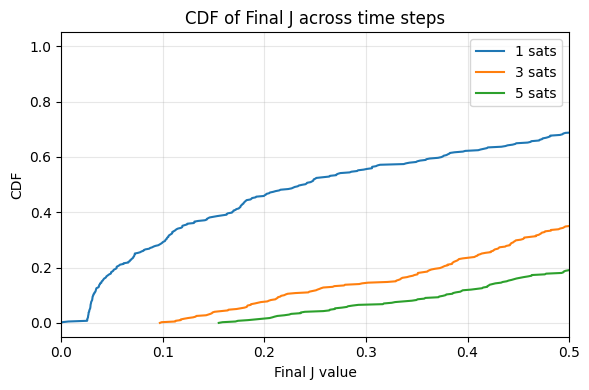

In [7]:
import json

data = []
with open("allarray7km.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        data.append(json.loads(line))
import numpy as np
from collections import defaultdict


J_last_by_k = defaultdict(list)

for entry in data:
    hist = entry.get("hist", {})
    J_series = hist.get("J", [])
    if len(J_series) == 0:
        continue
    k = entry.get("k")
    J_last = np.real(J_series[-1])  
    J_last_by_k[k].append(J_last)
    
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

for k_sel in sorted(J_last_by_k.keys()):
    vals = np.sort(np.array(J_last_by_k[k_sel]))
    cdf = np.linspace(0, 1, len(vals))
    plt.plot(vals, cdf, label=f"{k_sel} sats")

plt.xlabel("Final J value")
plt.ylabel("CDF")
plt.grid(True, alpha=0.3)
plt.legend()
plt.title("CDF of Final J across time steps")
plt.xlim(0, 0.5) 
plt.tight_layout()
plt.show()

In [8]:
import json
import matplotlib.pyplot as plt

def inspect_J_curve(filepath, method, step_idx):
    """
    检查结果文件中某个方法(method)和时间步(step_idx)对应的 J 曲线。
    
    Args:
        filepath : str, JSONL 文件路径 (如 "results_hist.jsonl")
        method   : str, 方法名 (例如 "MirrorProx" 或 "BestResp")
        step_idx : int, 要查看的 step 索引 (即你的 for 循环中的 step_idx)
    Returns:
        int : J 的长度
    """
    # 逐行读取文件
    with open(filepath, "r", encoding="utf-8") as f:
        entries = [json.loads(line) for line in f if line.strip()]
    
    # 过滤出对应的方法和step
    matches = [e for e in entries if e.get("method") == method and e.get("step_idx") == step_idx]
    
    if len(matches) == 0:
        print(f"⚠️ 没找到 method='{method}', step={step_idx} 的数据")
        return None
    
    # 通常每个 step 可能有多个 k（1,3,5）
    for e in matches:
        k = e.get("k")
        hist = e.get("hist", {})
        J = hist.get("J", [])
        if not J:
            print(f"⚠️ k={k} 没有 J 数据")
            continue
        
        print(f"✅ method={method}, step={step_idx}, k={k}, len(J)={len(J)}")
        plt.plot(J, label=f"{method} k={k} (len={len(J)})")

    plt.xlabel("Iteration")
    plt.ylabel("J value")
    plt.title(f"J evolution: method={method}, step={step_idx}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return


✅ method=BestResp, step=11, k=1, len(J)=400
✅ method=BestResp, step=11, k=3, len(J)=400
✅ method=BestResp, step=11, k=5, len(J)=400


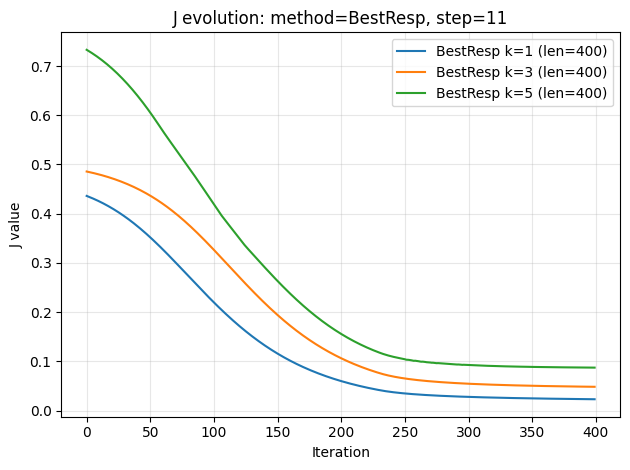

In [9]:
inspect_J_curve("allarray1km.jsonl", method="BestResp", step_idx=11)